# 1. Data Background and Problem Formulation

In this project, a dataset is given with 900+ data each corresponding to individual indicators of users' experience surveys revolving around proposed system designs -- and how would potential users react or perceive this notion. 

The goal is to provide a deep learning model with an acceptable rate of AUC (0.7 to 0.9) on test dataset in order to be able to predict certain words clearly.

To gain a better sense of the data, we first import the necessities to run the overall code.

---


In [1]:
# Configure output settings to prettify print display

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
# Ignore warnings to prettify print

import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install scikit-multilearn
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import imblearn

You should consider upgrading via the 'c:\users\chari\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## 1.1. Importing the data
We can then import the data via `pandas` package to see the overall nature of the data, the outputs, and the datatypes.

In [5]:
df = pd.read_excel('Sample.xlsx', sheet_name='PROMISE-Extended_Ivan33')
df.drop(columns=['ID', 'ProjectID', 'Class'], axis=1, inplace=True)
df.sample(n=10, random_state=1)

Requirements  \
718  Secure data transfer over the Internet could b...   
637  The system shall validate the amount is availa...   
759  Sensitive data will be encrypted before being ...   
366  PME Subsystem shall allow building product men...   
543  The system shall be responsive. At the DePaul ...   
41   The product shall synchronize with the office ...   
120  Program Administrators and Nursing Staff Membe...   
725  It must be able to download the most recent me...   
795  Customer must logout of the site after purchas...   
672  Changes made to the Manage My ID website can b...   

     obstructive<==>supportive  complicated<==>easy  inefficient<==>efficient  \
718                          7                    5                         6   
637                          7                    6                         7   
759                          7                    6                         7   
366                          5                    4                         6   
543                          6                    6                         7   
41                           5                    5                         5   
120                          6                    5                         6   
725                          6                    7                         6   
795                          3                    2                         3   
672                          4                    3                         4   

      confusing<==>clear  boring<==>exciting  not interesting<==>interesting  \
718                    6                   3                               4   
637                    7                   2                               3   
759                    7                   4                               4   
366                    5                   3                               4   
543                    7                   5                               6   
41                     5                   5                               4   
120                    5                   5                               4   
725                    7                   3                               4   
795                    2                   1                               2   
672                    3                   3                               4   

     conventional<==>inventive  usual<==>leading edge  
718                          3                      3  
637                          1                      1  
759                          2                      3  
366                          4                      4  
543                          3                      4  
41                           4                      5  
120                          3                      2  
725                          3                      3  
795                          4                      6  
672                          4                      5

In [6]:
data=df.copy()
df.columns

Index(['Requirements', 'obstructive<==>supportive', 'complicated<==>easy',
       'inefficient<==>efficient', ' confusing<==>clear', 'boring<==>exciting',
       'not interesting<==>interesting', 'conventional<==>inventive',
       'usual<==>leading edge'],
      dtype='object')

In [7]:
data['mix']=data['obstructive<==>supportive']+data['complicated<==>easy']+data['inefficient<==>efficient']+data[' confusing<==>clear']+data['boring<==>exciting']+data['not interesting<==>interesting']+data['conventional<==>inventive']+data['usual<==>leading edge']

In [8]:
data.head()

Requirements  \
0  The system shall refresh the display every 60 ...   
1  The application shall match the color of the s...   
2  If projected  the data must be readable.  On a...   
3  The product shall be available during normal b...   
4  If projected  the data must be understandable....   

   obstructive<==>supportive  complicated<==>easy  inefficient<==>efficient  \
0                          3                    4                         3   
1                          7                    2                         5   
2                          7                    4                         7   
3                          7                    2                         7   
4                          7                    2                         7   

    confusing<==>clear  boring<==>exciting  not interesting<==>interesting  \
0                    3                   4                               3   
1                    5                   3                               3   
2                    7                   5                               5   
3                    5                   5                               5   
4                    7                   5                               7   

   conventional<==>inventive  usual<==>leading edge  mix  
0                          6                      6   32  
1                          6                      6   37  
2                          5                      4   44  
3                          5                      6   42  
4                          3                      3   41

## 1.2. Column Definitions
### 1.2.1. Features

Features are only represented in the first column, which is the `Requirements` column. This column represents the question and/or the funcionalities of the system itself.

### 1.2.2. Labels

Labels, on the other hand, comprised of 8 columns in total. They are:
* **obstructive<==>supportive**, measuring supportiveness.
* **complicated<==>easy**, measuring ease-of-use.
* **inefficient<==>efficient**, measuring efficiency.
* **confusing<==>clear**, measuring brevity and clarity.
* **boring<==>exciting**, measuring excitement.
* **not interesting<==>interesting**, measuring appeal.
* **conventional<==>inventive**, measuring innovation.
* **usual<==>leading edge**, measuring technology usage.

The scales on the labels vary from 1 to 7, in which values closer to 1 corresponds to a more negative connotation, while values closer to 7 is likely to be more positive.

For example, for column `boring<==>exciting`, if a user gives it a 3, whilst this may seem neutral at first glance, we can infer that the user does not regard this system design as easy-to-use -- otherwise they would give it a score of 5 or 6.

For this task, we'll run multiclass multilabel regression since we obtained a good AUC with multiclass regression on one column before with simple regression. **The trick here is to not use a single column.**

With this, we might want to approach the problem within the scope of [Multi-output Regression](https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/)

First, we separate the labels from the data.

In [9]:
features = df.iloc[:, 0].values # First column in the entire set
labels = df.iloc[:, np.r_[1:9]].values
print("Features is now of type:", type(features), "with shape", features.shape)
print("Labels is now of type:", type(labels), "with shape", labels.shape)

Features is now of type: <class 'numpy.ndarray'> with shape (969,)
Labels is now of type: <class 'numpy.ndarray'> with shape (969, 8)


We know from previous work that the dataset is very much imbalanced, so we would want to try oversampling across all columns and make them our new label. But first, we would want to convert features as word vectors first.

## 1.3. Quick EDA

We can visualize the most used words via `wordcloud` used in our dataset.

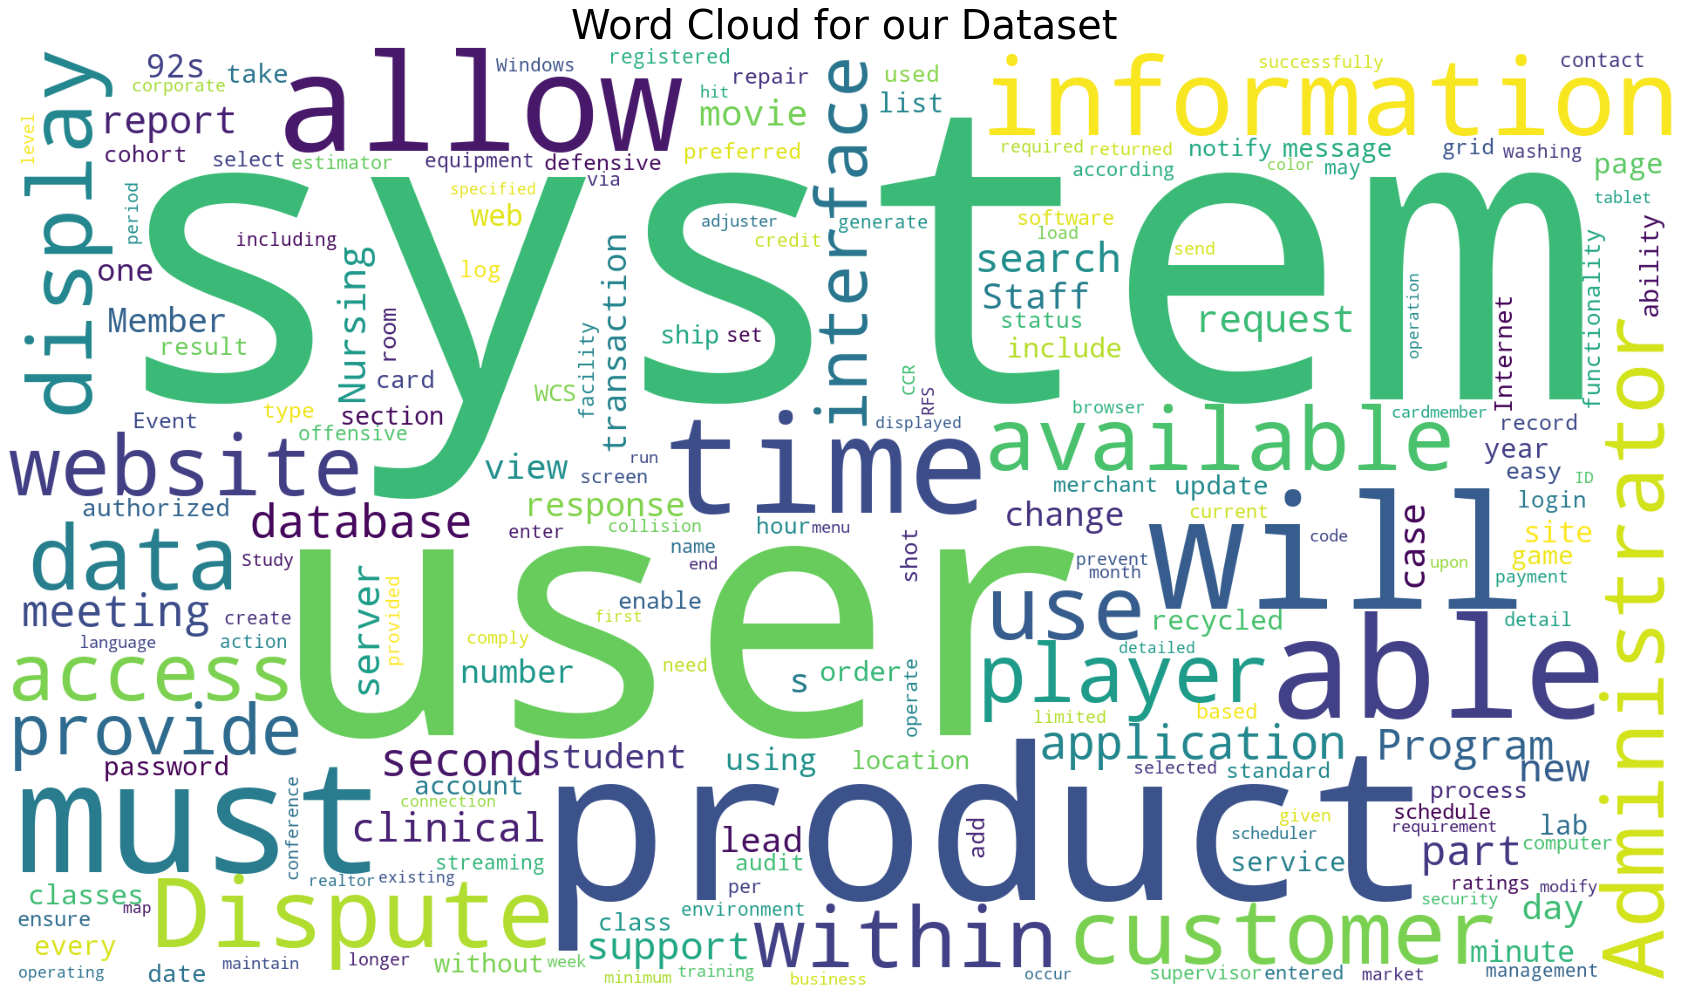

In [10]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(30,20))
text =df['Requirements'].values
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1920,
                          height=1080
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Word Cloud for our Dataset",fontsize=40)
plt.imshow(cloud)

In [11]:
from collections import Counter
for i in range(8):
  print("Column:", df.columns[1:][i])
  print(Counter(labels[:,i]))

Column: obstructive<==>supportive
Counter({7: 418, 6: 281, 5: 152, 4: 63, 3: 37, 2: 16, 1: 2})
Column: complicated<==>easy
Counter({6: 278, 5: 254, 7: 210, 4: 144, 3: 57, 2: 24, 1: 2})
Column: inefficient<==>efficient
Counter({7: 406, 6: 306, 5: 128, 4: 71, 3: 36, 2: 18, 1: 4})
Column:  confusing<==>clear
Counter({7: 443, 6: 245, 5: 148, 4: 68, 3: 38, 2: 23, 1: 4})
Column: boring<==>exciting
Counter({3: 256, 4: 249, 5: 185, 2: 142, 6: 89, 7: 26, 1: 22})
Column: not interesting<==>interesting
Counter({4: 265, 3: 245, 5: 222, 2: 103, 6: 92, 7: 23, 1: 19})
Column: conventional<==>inventive
Counter({3: 273, 2: 267, 4: 164, 5: 102, 1: 101, 6: 55, 7: 7})
Column: usual<==>leading edge
Counter({3: 259, 2: 253, 4: 177, 5: 112, 1: 101, 6: 61, 7: 6})


# 2. Pre-processing
---

## 2.1. Tokenization

Tokenization means splitting each word and vectorizing a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary). This process cleans up our text, lowercase, and remove punctuations. This step is basically the same from our previous work involving LSTMs.

This way, we can see which words appear the most in our training set.

In [12]:
tokenizer = Tokenizer(num_words = 2000, oov_token="<OOV>")
tokenizer.fit_on_texts(features)
word_index = tokenizer.word_index
dict(list(word_index.items())[:10])

{'<OOV>': 1,
 'the': 2,
 'shall': 3,
 'to': 4,
 'system': 5,
 'of': 6,
 'be': 7,
 'a': 8,
 'and': 9,
 'product': 10}

After tokenization, the next step is to turn those tokens into lists of sequence.

In [13]:
sequences = tokenizer.texts_to_sequences(features)
print(sequences[0]) # This corresponds to the first sentence in the training data.

[2, 5, 3, 674, 2, 32, 96, 675, 49]


## 2.2. Padding

When we train neural networks for NLP, we need sequences to be in the same size, that's why we use padding. Padding means that we convert all instances of the training data towards the same size. To do this, we need to specify a fixed length to transform all the instances on.

For the project, we can set the sequence by looking quickly at the average proportion of the training words.

In [14]:
import math
word_counts = []
for i in (features):
  word_counts.append(len(i.split(" ")))
print("Average word counts:" , sum(word_counts)/len(word_counts))

# Round max length of padding to the nearest tenth
max_length = math.ceil((sum(word_counts)/len(word_counts))/10) * 10
print("Padded onto length: ", max_length)

# Delete unused variable
del word_counts 

Average word counts: 18.223942208462333
Padded onto length:  20


We can then proceed to do the actual padding. This is done for all instances of the training example.

In [15]:
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

for i in range(5):
  print("Sequence of length", len(sequences[i]), "was padded onto", len(padded[i]))

Sequence of length 9 was padded onto 20
Sequence of length 16 was padded onto 20
Sequence of length 29 was padded onto 20
Sequence of length 36 was padded onto 20
Sequence of length 35 was padded onto 20


In [16]:
padded

array([[  2,   5,   3, ...,   0,   0,   0],
       [  2,  45,   3, ...,   0,   0,   0],
       [ 69, 879,   2, ...,  17,   4, 451],
       ...,
       [  2,   1,  36, ...,  91, 309,  12],
       [  2,   5,   3, ...,   9, 102,   4],
       [  2,  36,  15, ..., 304,  15,   7]])

## 2.3. SMOTE Oversampling

Generally, oversampling makes fake data so that the minority labels are not squashed by the majority.

Constraint of using SMOTE within this dataset is that it's very fragile to classes with only one example. Since SMOTE works via k-nearest neighbors, at least two members of a class would be mandatory for it to work.

Synthetic samples generated with respect to the most amount of classes in all columns so that input shape (features and labels) are consistent against each other.

## REVISION: ROS Oversampling

ROS generates random data as opposed to the better, more superior SMOTE which generates "more credible" data. We can't use SMOTE on all sheets because of the `n_neighbors` and distance constraint.

We find the least common multiple of all class members amount, and oversample from there to get the matrix dimensions uniform.

In [17]:
import copy
from collections import defaultdict, Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler
max_amount = np.lcm.reduce([1,2,3,4,5,6,7]) * 40
labels_processed = np.zeros((max_amount, 8))

for i in range(8):
  unique_classes = np.unique(df[df.columns[1:][i]])
  amount = [int(
      (max_amount/len(unique_classes)))
      ] * len(unique_classes)
  x = {k:v for (k,v) in zip(unique_classes, amount)}
  smt = RandomOverSampler(sampling_strategy=x)
  X, y = smt.fit_resample(padded, labels[:,i])
  labels_processed[:,i] = y
  print("Column", i, "done.")
  # We don't save nor use the X variable between each iteration, 
  # instead only using the last one.


print("Shape of input features is:", X.shape)
print("Shape of labels is:",labels_processed.shape)

Column 0 done.
Column 1 done.
Column 2 done.
Column 3 done.
Column 4 done.
Column 5 done.
Column 6 done.
Column 7 done.
Shape of input features is: (16800, 20)
Shape of labels is: (16800, 8)


In [18]:
# Sanity check time!
for i in range(8):
  print("For column", df.columns[1:][i])
  print(Counter(labels_processed[:,i]),"\n------")


print("First ten entries of the processed labels:\n", labels_processed[:10,:])
print("First ten entries of the processed features:\n", X[:10,:])

# Last and final assertion to catch matrix errors
try:
  assert(X.shape[0] == labels_processed.shape[0])
  print("Assertion completed!")
except AssertionError:
  print("Error!\nShape of X is", X.shape, "while labels is", labels_processed.shape)
  raise AssertionError

For column obstructive<==>supportive
Counter({3.0: 2400, 7.0: 2400, 5.0: 2400, 6.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400}) 
------
For column complicated<==>easy
Counter({4.0: 2400, 2.0: 2400, 3.0: 2400, 6.0: 2400, 1.0: 2400, 5.0: 2400, 7.0: 2400}) 
------
For column inefficient<==>efficient
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 6.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400}) 
------
For column  confusing<==>clear
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 6.0: 2400, 1.0: 2400, 4.0: 2400, 2.0: 2400}) 
------
For column boring<==>exciting
Counter({4.0: 2400, 3.0: 2400, 5.0: 2400, 2.0: 2400, 6.0: 2400, 7.0: 2400, 1.0: 2400}) 
------
For column not interesting<==>interesting
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 4.0: 2400, 6.0: 2400, 2.0: 2400, 1.0: 2400}) 
------
For column conventional<==>inventive
Counter({6.0: 2400, 5.0: 2400, 3.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400, 7.0: 2400}) 
------
For column usual<==>leading edge
Counter({6.0: 2400, 4.0: 2400, 3.0: 2400, 2.0: 2400, 5.0: 

## 2.4. Train-test Splitting

Finally we get to this part. We can use sklearn's `train_test_split` to do the usual splitting for test set (validation set is specified within building the model in the next section).

Also, specifying `random_state` ensures reproducibility.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels_processed, test_size=0.2, random_state=42)

# Sanity check again and again
print("Training examples:", X_train.shape)
print("Training labels:", y_train.shape)
print("Test examples:", X_test.shape)
print("Test labels:", y_test.shape)

Training examples: (13440, 20)
Training labels: (13440, 8)
Test examples: (3360, 20)
Test labels: (3360, 8)


In [20]:
from keras import backend
 
def rmse(y_true, y_pred):
   return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
 

In [46]:
data = {'metric':['Accuracy', 'Precision', 'Recall', 'F1 Score','RMSE','AUC score']}
metric_df=pd.DataFrame(data)

In [47]:
metric_df.set_index(['metric'])



Empty DataFrame
Columns: []
Index: [Accuracy, Precision, Recall, F1 Score, RMSE, AUC score]

# 3. Modelling

## 3.1. Building the Model

Since we're training on augmented data, we're going to approach this as conventional regression compared to the LSTM approach we're doing it before.

LSTM model in this manner would result in a pretty bad metric score (around 0.5 to 0.7 F1-score) whereas our fully-connected dense layers resulted in a pretty satisfying F1, which is around 0.8 to 1 for each column.

In [21]:
# Wrapper functions for result interpretation
from matplotlib import pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def transform_results(estimates):
  res = []
  for x in estimates:
    if x > 7:
      x = 7
      res.append(x)
    else:
      res.append(x)
  return res

In [22]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initializer = tf.keras.initializers.RandomNormal(seed=1) # Reproducibility

model = Sequential(name="classifier_NN")
model.add(tf.keras.Input(shape=(X_train.shape[1],))) # Automatically detect features as input nodes
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(8)) # output layer
opt = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[rmse], optimizer = opt)
model.summary()

Model: "classifier_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)             

Epoch 1/150
588/588 - 2s - loss: 4.6035 - rmse: 1.7771 - val_loss: 2.4774 - val_rmse: 1.2840
Epoch 2/150
588/588 - 1s - loss: 2.1164 - rmse: 1.2283 - val_loss: 1.4775 - val_rmse: 0.9962
Epoch 3/150
588/588 - 1s - loss: 1.5781 - rmse: 1.0402 - val_loss: 2.1205 - val_rmse: 1.2269
Epoch 4/150
588/588 - 1s - loss: 1.4276 - rmse: 0.9716 - val_loss: 1.1510 - val_rmse: 0.8493
Epoch 5/150
588/588 - 1s - loss: 1.2373 - rmse: 0.8851 - val_loss: 0.8991 - val_rmse: 0.7279
Epoch 6/150
588/588 - 1s - loss: 1.1205 - rmse: 0.8270 - val_loss: 0.9645 - val_rmse: 0.7643
Epoch 7/150
588/588 - 1s - loss: 1.0134 - rmse: 0.7712 - val_loss: 0.8263 - val_rmse: 0.6663
Epoch 8/150
588/588 - 1s - loss: 0.9513 - rmse: 0.7378 - val_loss: 0.8596 - val_rmse: 0.7106
Epoch 9/150
588/588 - 1s - loss: 0.9028 - rmse: 0.7119 - val_loss: 0.8057 - val_rmse: 0.6577
Epoch 10/150
588/588 - 1s - loss: 0.8592 - rmse: 0.6890 - val_loss: 0.7993 - val_rmse: 0.6559
Epoch 11/150
588/588 - 1s - loss: 0.8817 - rmse: 0.6929 - val_loss: 0

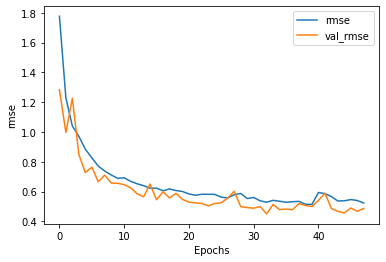

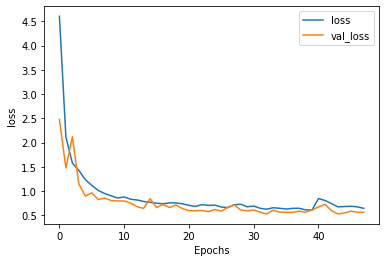

In [23]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(X_train, y_train, epochs=150, batch_size = 16, validation_split=0.3, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=2)

plot_graphs(history, "rmse")
plot_graphs(history, "loss")

In [24]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - ETA: 0s - loss: 0.5413 - rmse: 0.45 - 5s 1ms/step - loss: 0.5419 - rmse: 0.4586
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 54.19%
rmse: 45.86%


## 3.2. Result Interpretation and Evaluation

Here we evaluate on `y_test`, which we made sure earlier comes from a similar distribution within the training set itself. 

Resulted on a pretty confident `mae` and `mse`, which I would say a good result considering the number of classes we have.

In [33]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 2s 695us/step - loss: 0.5683 - rmse: 0.4818
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 56.83%
rmse: 48.18%


We can also print classification report from each column.

In [34]:
from sklearn.metrics import classification_report, f1_score
y_pred = model.predict(X_test)
for i in range(8):
  print("Column", df.columns[1:][i])
  estimates = [round(float(x)) for x in y_pred[:,i]]
  estimates = transform_results(estimates)
  print(np.unique(estimates))
  print(classification_report(y_test[:,i], estimates), "\n------")

Column obstructive<==>supportive
[1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         1.0       0.94      0.94      0.94       462
         2.0       0.78      0.45      0.57       482
         3.0       0.50      0.61      0.55       510
         4.0       0.59      0.66      0.62       517
         5.0       0.56      0.69      0.62       467
         6.0       0.64      0.62      0.63       470
         7.0       0.81      0.69      0.74       452

    accuracy                           0.66      3360
   macro avg       0.69      0.67      0.67      3360
weighted avg       0.68      0.66      0.66      3360
 
------
Column complicated<==>easy
[1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         1.0       0.94      0.94      0.94       463
         2.0       0.81      0.55      0.66       485
         3.0       0.55      0.63      0.59       501
         4.0       0.61      0.68      0.64       515
         5.0       0.62      0.7

## 3.3. Prepare the Plotting Set

Due to the multi-dimensional nature of our results and test set, we need to reshape the predictions by using `numpy`'s `flatten()` attribute, which flattens the array column-wise if we specify the argument `order='F'` to flatten in Fortran-style order.

Keep in mind this will indeed aggregate the metrics like on the `classification_report()` below.

In [35]:
y_pred_flattened = y_pred.flatten(order='F')
y_test_flattened = y_test.flatten(order='F')
y_classified = [round(float(x)) for x in y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test_flattened[:10])
print("Predicted labels:",y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test_flattened, y_classified))

First ten examples of the test set:
Truth labels: [2. 1. 2. 1. 4. 3. 4. 3. 3. 7.]
Predicted labels: [2, 1, 3, 1, 5, 4, 4, 3, 4, 1]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.94      0.95      0.94      3691
         2.0       0.83      0.60      0.70      3921
         3.0       0.60      0.67      0.63      3952
         4.0       0.68      0.75      0.71      4161
         5.0       0.70      0.82      0.75      3786
         6.0       0.75      0.77      0.76      3748
         7.0       0.92      0.78      0.84      3621

    accuracy                           0.76     26880
   macro avg       0.77      0.76      0.76     26880
weighted avg       0.77      0.76      0.76     26880



In [36]:
# Wrapper function(s) from earlier notebook
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
  """
  Modified function behavior, now predicts column-wise
  """
  y_score = clf.predict_proba(X_test)
  target_names = np.unique(y_test)
  # structures
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  # calculate dummies once
  y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
  print(y_test_dummies.shape, y_score.shape)
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  
# roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic')
    
  for i in range(len(target_names)):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], target_names[i]))
  
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()

  return roc_auc

def plot_multiclass_roc_LSTM(X_test, y_test, n_classes, figsize=(17, 6), model=model):
  """
  Custom-made function to plot ROC curve.
  Sorry I can't run because I don't have the excel file used for this particular notebook.
  """
  y_score = to_categorical(y_test)
  target_names = ["obstructive vs supportive",
                  "complicated vs easy",
                  "inefficient vs efficient",
                  " confusing vs clear",
                  "boring vs exciting",
                  "not interesting vs interesting",
                  "conventional vs inventive",
                  "usual vs leading edge"]
  # structures
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
 
  # One-liner transformation of our existing result 
  y_test_dummies = np.pad(pd.get_dummies(y_classified, drop_first=False).values, 
                          ((0,0), 
                           (min(labels.flatten()),0)))
  print(y_test_dummies.shape, y_score.shape) # Quick debug purposes after one-hot encoding
                                             # to ensure matrix dimension is right
  for i in range(1, n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  
# roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Column-wise Receiver Operating Characteristic Plot')
    
  for i in range(1, len(target_names)):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], target_names[i]))
  
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()


# plot_multiclass_roc_LSTM(X_test, y_classified, 8, figsize=(17, 6))

ROC AUC score: 0.8591009669185626


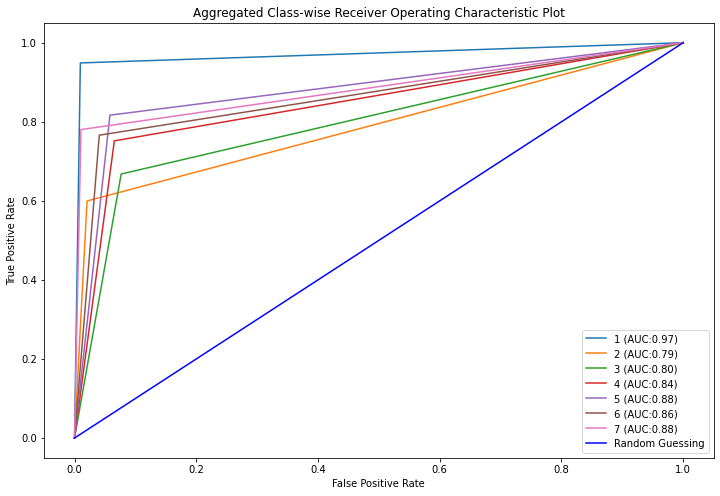

In [37]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


def score_auc(y_test, y_pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(set(labels.flatten())):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test_flattened, y_classified))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('Aggregated Class-wise Receiver Operating Characteristic Plot')
plt.savefig("auc.png")
plt.show()

## 3.4. Exporting the Model

We can export the model to `HDF5` format designed to store large amounts of information. More info:
* [Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_Data_Format)
* [TensorFlow Documentation](https://www.tensorflow.org/tutorials/keras/save_and_load#hdf5_format)

In [30]:
model.save('UX_Regression.h5')

## 3.5. XGB Method
For comparison, we try implementing XGB.

For column: obstructive<==>supportive
[15:19:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.88      0.86       482
         3.0       0.76      0.74      0.75       510
         4.0       0.68      0.68      0.68       517
         5.0       0.66      0.65      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.78      0.78      0.78      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [ 

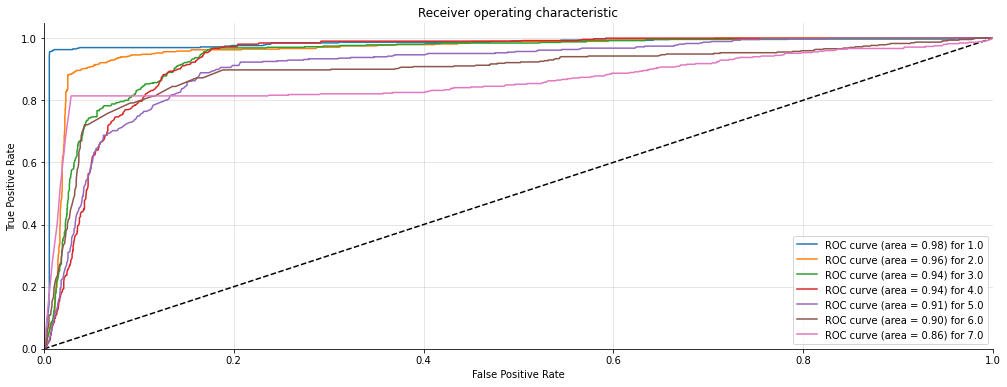

For column: complicated<==>easy
[15:20:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.85      0.88      0.87       485
         3.0       0.75      0.76      0.76       501
         4.0       0.70      0.68      0.69       515
         5.0       0.71      0.74      0.73       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.81      3360
   macro avg       0.82      0.82      0.82      3360
weighted avg       0.81      0.81      0.81      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  0 428

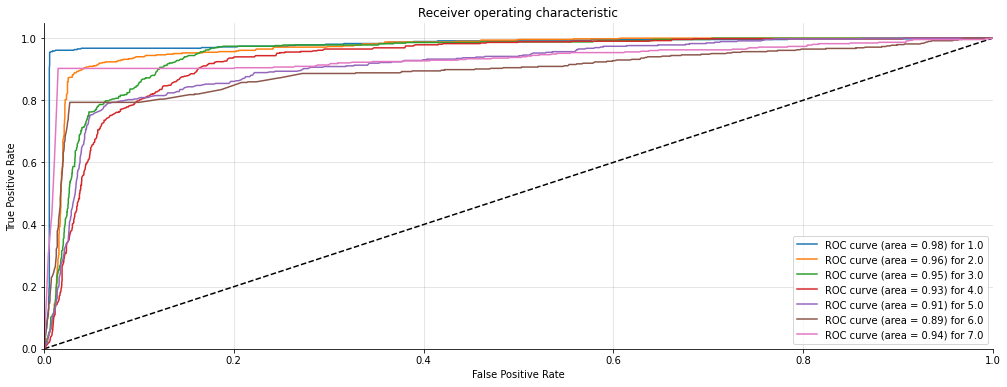

For column: inefficient<==>efficient
[15:20:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.88      0.86       482
         3.0       0.74      0.75      0.74       506
         4.0       0.69      0.66      0.67       526
         5.0       0.66      0.67      0.66       458
         6.0       0.73      0.71      0.72       475
         7.0       0.82      0.83      0.83       451

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.77      0.78      0.78      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  

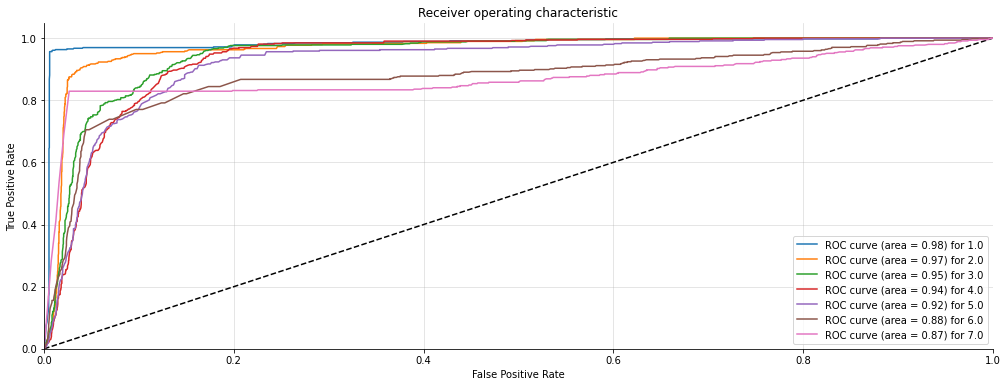

For column:  confusing<==>clear
[15:20:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.84      0.87      0.86       488
         3.0       0.76      0.74      0.75       506
         4.0       0.68      0.68      0.68       516
         5.0       0.66      0.67      0.67       456
         6.0       0.73      0.72      0.72       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.78      0.78      0.78      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  0 426

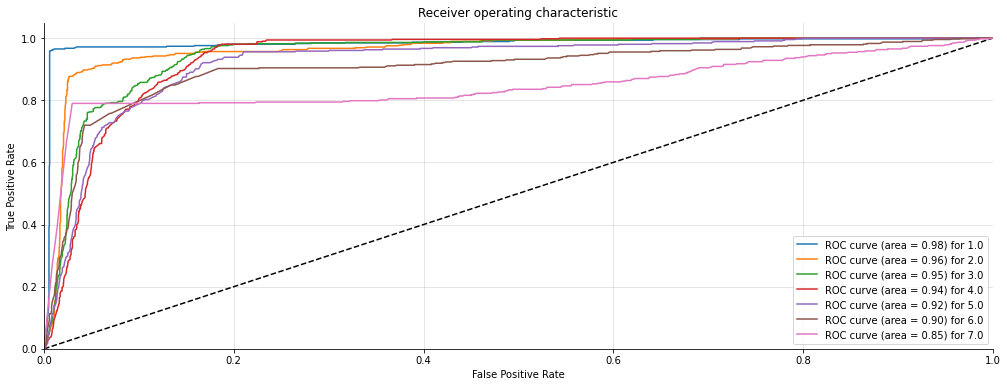

For column: boring<==>exciting
[15:20:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.88       491
         3.0       0.83      0.82      0.82       487
         4.0       0.86      0.87      0.87       518
         5.0       0.92      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  5 434 

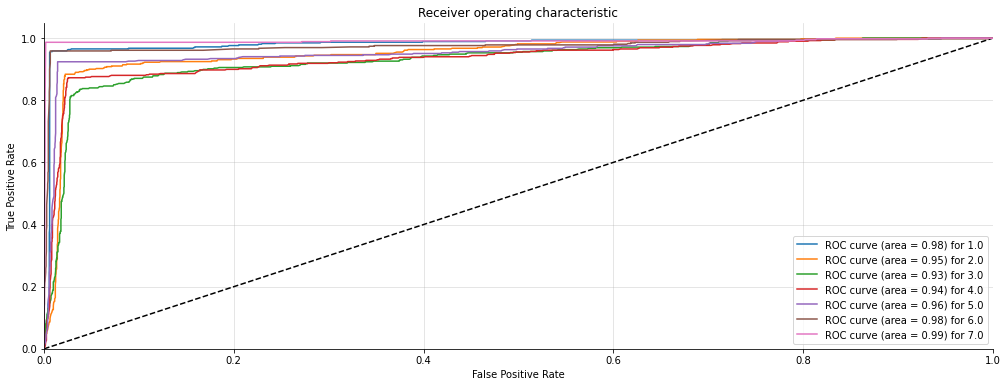

For column: not interesting<==>interesting
[15:20:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.86      0.87      0.87       495
         3.0       0.81      0.78      0.80       490
         4.0       0.83      0.83      0.83       519
         5.0       0.88      0.91      0.89       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0

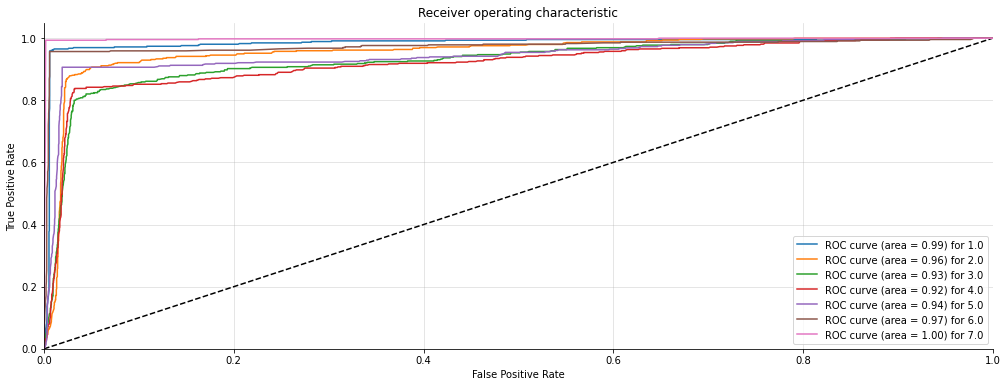

For column: conventional<==>inventive
[15:20:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.97      0.95      0.96       502
         3.0       0.94      0.95      0.95       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [ 

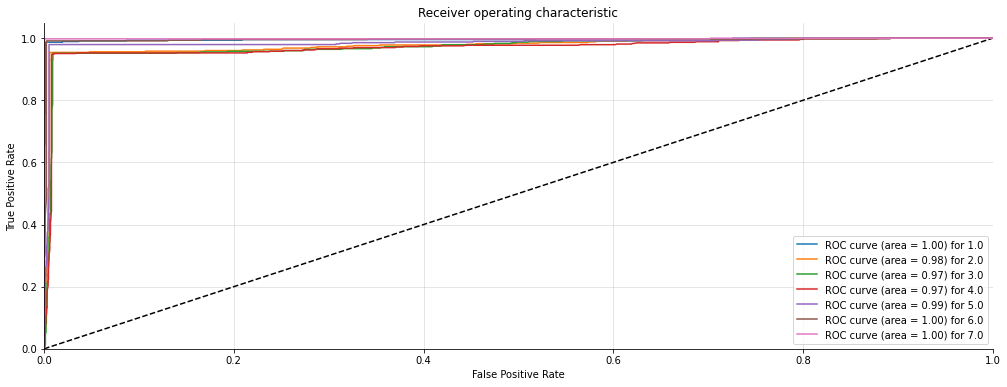

For column: usual<==>leading edge
[15:20:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 4

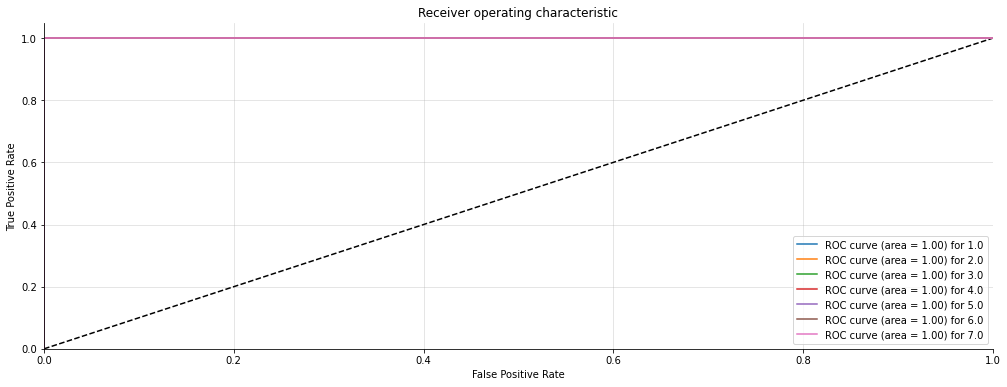

In [50]:
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error

acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def XGBmodel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    xgb_classifier = XGBClassifier()
    xgb_classifier.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in xgb_classifier.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(xgb_classifier, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  XGBmodel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))


In [51]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE -score :{}".format(np.mean(rms)))
print("average AUC -score :{}".format(np.mean(aucscore)))
metric_df['XGB'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8652157738095239
average Precision :0.8650274010838007
average Recall :0.8652157738095239
average F1 -score :0.8650464490002978
average RMSE -score :0.598529874918185
average AUC -score :0.9211821463252646


## 3.6. SVM Method

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.49      0.90      0.64       462
         2.0       0.61      0.58      0.59       482
         3.0       0.64      0.46      0.54       510
         4.0       0.58      0.39      0.47       517
         5.0       0.55      0.49      0.52       467
         6.0       0.64      0.61      0.63       470
         7.0       0.78      0.81      0.80       452

    accuracy                           0.60      3360
   macro avg       0.61      0.61      0.60      3360
weighted avg       0.61      0.60      0.59      3360

Confusion Matrix: 
 [[416  27   3   1   1   8   6]
 [121 279  47   9  12  12   2]
 [ 86  60 236  85  23  17   3]
 [ 82  42  42 201 124  18   8]
 [ 80  16  15  30 230  96   0]
 [ 38  18  13   9  19 288  85]
 [ 20  18  13  12  11  10 368]]
Accuracy Score : 0.6005952380952381
Precision Score : 0.6117843856358323
Recall Score : 0.6005952380952381
F1 Score : 0.5926402

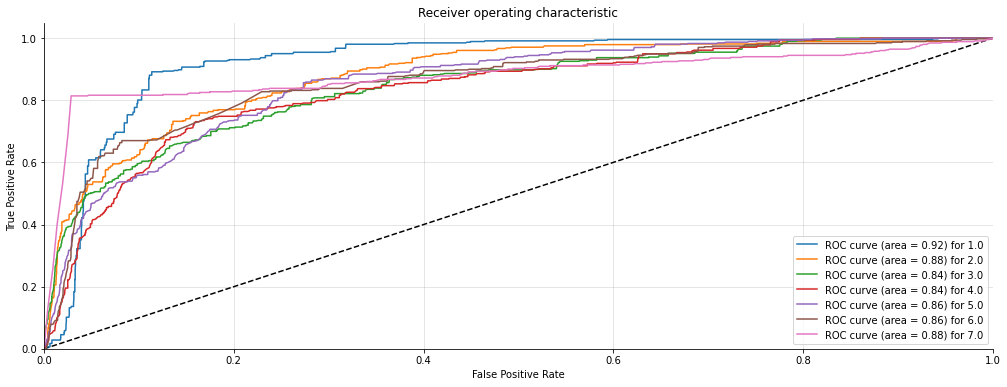

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.49      0.89      0.63       463
         2.0       0.61      0.55      0.58       485
         3.0       0.65      0.48      0.55       501
         4.0       0.60      0.41      0.49       515
         5.0       0.62      0.53      0.58       460
         6.0       0.70      0.72      0.71       484
         7.0       0.88      0.90      0.89       452

    accuracy                           0.64      3360
   macro avg       0.65      0.64      0.63      3360
weighted avg       0.65      0.64      0.63      3360

Confusion Matrix: 
 [[412  27   3   1   1  13   6]
 [123 269  44  15  17  15   2]
 [ 84  53 239  86  15  22   2]
 [ 93  38  40 212 107  22   3]
 [ 78  22  20  22 246  72   0]
 [ 38  18  16  13   5 350  44]
 [ 15  13   4   5   4   3 408]]
Accuracy Score : 0.6357142857142857
Precision Score : 0.649490219325846
Recall Score : 0.6357142857142857
F1 Score : 0.62916083708772

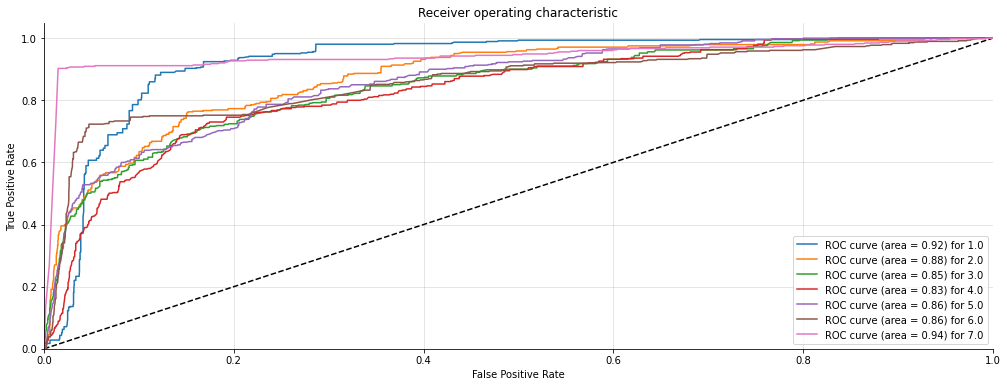

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.49      0.90      0.63       462
         2.0       0.62      0.56      0.59       482
         3.0       0.64      0.48      0.55       506
         4.0       0.58      0.38      0.46       526
         5.0       0.54      0.51      0.53       458
         6.0       0.63      0.59      0.61       475
         7.0       0.80      0.83      0.82       451

    accuracy                           0.60      3360
   macro avg       0.61      0.61      0.60      3360
weighted avg       0.61      0.60      0.59      3360

Confusion Matrix: 
 [[417  26   8   0   1   4   6]
 [123 272  49   9  11  16   2]
 [ 85  49 244  90  19  17   2]
 [ 88  45  43 201 128  18   3]
 [ 80  13   6  26 235  98   0]
 [ 40  17  18  11  32 278  79]
 [ 20  17  13  10   9   8 374]]
Accuracy Score : 0.6014880952380952
Precision Score : 0.6141128867256448
Recall Score : 0.6014880952380952
F1 Score : 0.59410484

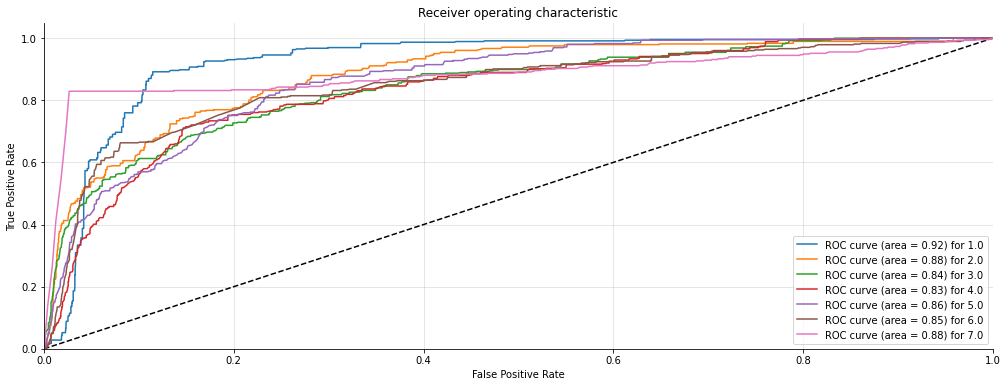

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.49      0.90      0.64       461
         2.0       0.60      0.56      0.58       488
         3.0       0.65      0.48      0.55       506
         4.0       0.58      0.39      0.47       516
         5.0       0.55      0.52      0.54       456
         6.0       0.63      0.59      0.61       471
         7.0       0.78      0.79      0.79       462

    accuracy                           0.60      3360
   macro avg       0.61      0.61      0.60      3360
weighted avg       0.61      0.60      0.59      3360

Confusion Matrix: 
 [[415  26   3   1   1   9   6]
 [123 275  49  10  13  16   2]
 [ 85  57 242  86  15  18   3]
 [ 82  44  38 200 125  19   8]
 [ 74  15  12  23 237  95   0]
 [ 39  17  13   7  29 280  86]
 [ 26  21  17  16   8   7 367]]
Accuracy Score : 0.6
Precision Score : 0.6126976999104823
Recall Score : 0.6
F1 Score : 0.5929302821102606
(3360, 7) (3360, 7)


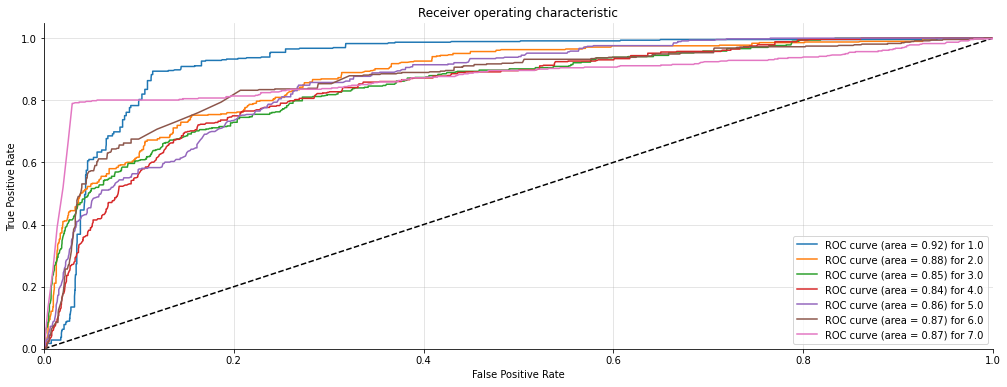

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.49      0.87      0.63       463
         2.0       0.66      0.56      0.60       491
         3.0       0.72      0.54      0.62       487
         4.0       0.73      0.56      0.63       518
         5.0       0.81      0.63      0.71       487
         6.0       0.78      0.87      0.82       462
         7.0       0.95      0.99      0.97       452

    accuracy                           0.71      3360
   macro avg       0.73      0.72      0.71      3360
weighted avg       0.73      0.71      0.71      3360

Confusion Matrix: 
 [[402  24   4   2   1  24   6]
 [124 273  46  21  10  17   0]
 [100  39 262  57  15  12   2]
 [ 78  42  32 289  41  26  10]
 [ 86  24  12  26 309  30   0]
 [ 29  12   8   2   3 403   5]
 [  0   0   1   1   1   3 446]]
Accuracy Score : 0.7095238095238096
Precision Score : 0.7333665219461414
Recall Score : 0.7095238095238096
F1 Score : 0.70803966161561

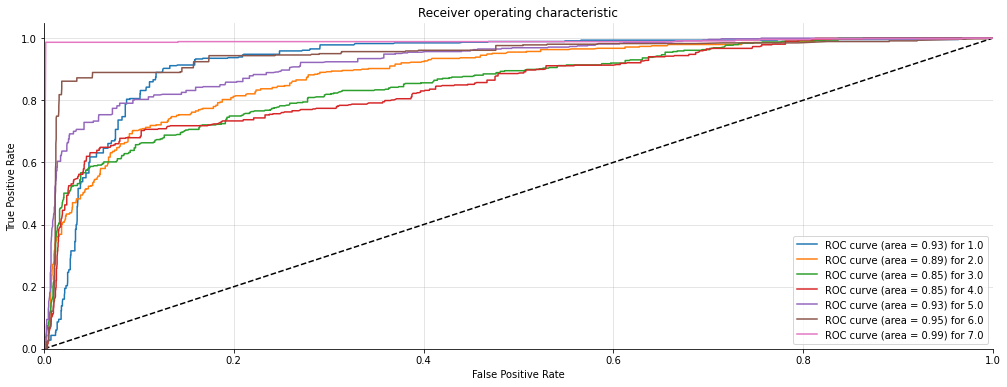

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.48      0.87      0.62       461
         2.0       0.64      0.56      0.60       495
         3.0       0.72      0.50      0.59       490
         4.0       0.72      0.54      0.61       519
         5.0       0.80      0.66      0.72       481
         6.0       0.80      0.87      0.83       465
         7.0       0.95      0.99      0.97       449

    accuracy                           0.70      3360
   macro avg       0.73      0.71      0.71      3360
weighted avg       0.73      0.70      0.70      3360

Confusion Matrix: 
 [[401  25   4   1   1  23   6]
 [124 275  42  23  12  17   2]
 [ 99  57 245  57  16  14   2]
 [ 84  47  31 278  46  23  10]
 [ 95  11  10  26 316  23   0]
 [ 29  12   8   2   5 404   5]
 [  0   0   1   1   0   1 446]]
Accuracy Score : 0.7038690476190477
Precision Score : 0.7279441174589879
Recall Score : 0.7038690476190477
F1 Score : 0.70

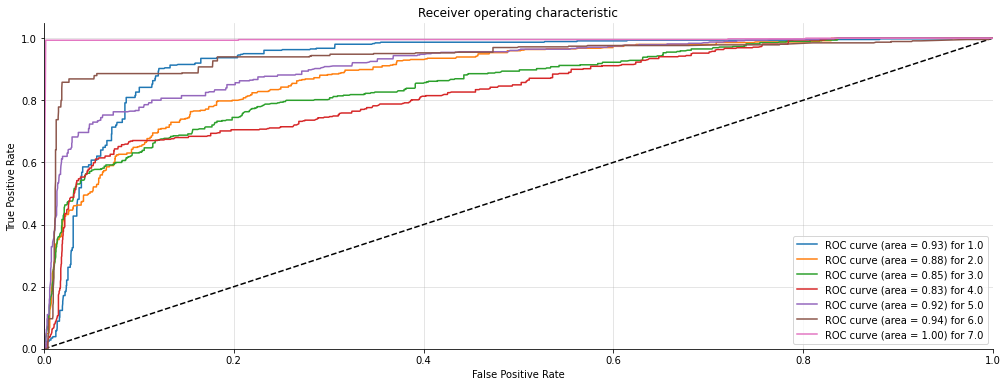

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.50      0.91      0.65       460
         2.0       0.74      0.61      0.67       502
         3.0       0.81      0.63      0.71       474
         4.0       0.85      0.61      0.71       527
         5.0       0.85      0.67      0.75       486
         6.0       0.79      0.89      0.84       459
         7.0       0.97      1.00      0.99       452

    accuracy                           0.75      3360
   macro avg       0.79      0.76      0.76      3360
weighted avg       0.79      0.75      0.75      3360

Confusion Matrix: 
 [[418   8   3   1   0  24   6]
 [128 304  20  20  14  15   1]
 [ 80  43 300  19  21   9   2]
 [ 84  37  33 321  19  30   3]
 [ 94  10  10  18 326  28   0]
 [ 30  10   6   0   3 410   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.7529761904761905
Precision Score : 0.7879548505009547
Recall Score : 0.7529761904761905
F1 Score : 0.7549350

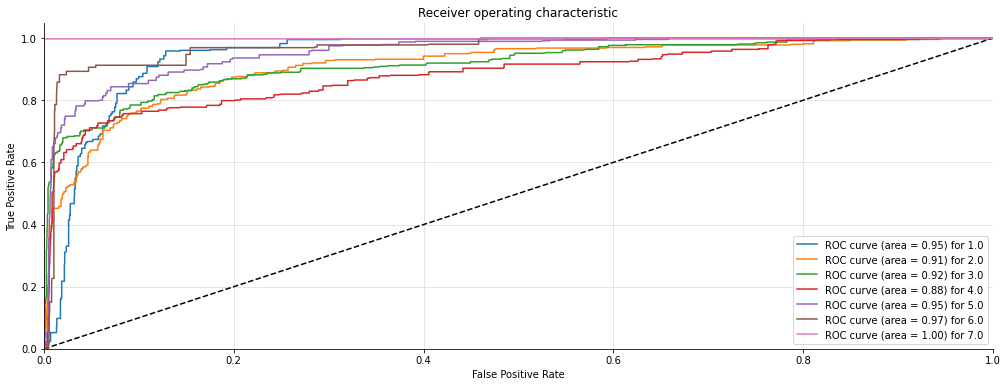

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.51      0.91      0.65       459
         2.0       0.78      0.65      0.71       496
         3.0       0.84      0.67      0.75       478
         4.0       0.89      0.65      0.75       523
         5.0       0.87      0.70      0.78       491
         6.0       0.82      0.90      0.86       462
         7.0       0.98      1.00      0.99       451

    accuracy                           0.78      3360
   macro avg       0.81      0.78      0.78      3360
weighted avg       0.81      0.78      0.78      3360

Confusion Matrix: 
 [[418   5   8   2   0  19   7]
 [123 321  12  15  11  14   0]
 [ 75  41 322  12  20   8   0]
 [ 82  27  28 338  20  25   3]
 [ 91  10   8  11 346  25   0]
 [ 29  10   6   0   0 417   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.7776785714285714
Precision Score : 0.8142828405316812
Recall Score : 0.7776785714285714
F1 Score : 0.78149655314

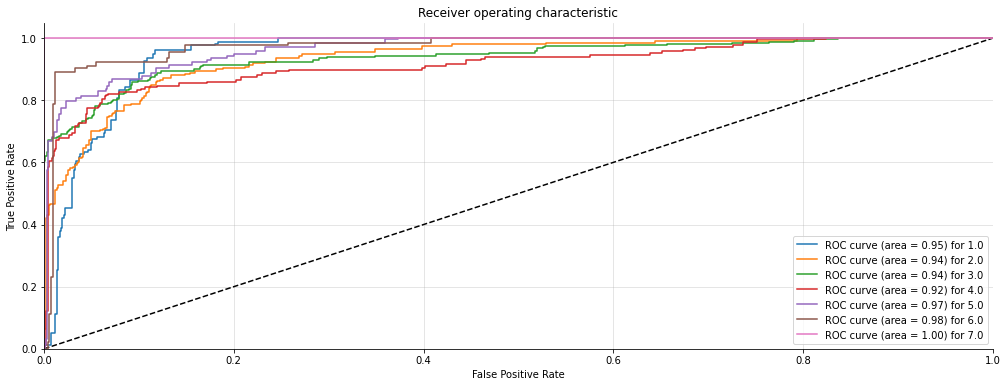

In [52]:
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def SVMmodel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    svc = SVC( probability=True)
    svc.fit(X_train, y_train)

    # predictions over test set
    predictions=[round(float(x)) for x in svc.predict(X_test)]
    print((classification_report(y_test, predictions)))

    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(svc, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  SVMmodel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [53]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE -score :{}".format(np.mean(rms)))
print("average auc score {}".format(np.mean(aucscore)))
metric_df['SVM'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.6727306547619047
average Precision :0.6939541902544464
average Recall :0.6727306547619047
average F1 -score :0.6693720110117757
average RMSE -score :1.4159654656148812
average auc score 0.8093631703532083


## 3.7. Custom-Built Ordinal Classifier

Credit: [Muhammad for Towards Data Science](https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c)

Ordinal classifier basically does a similar thing to one-hot encoding -- but despite having one value each column, ordinal encoding maps unique binary values for each of our unique classes.

We implement a custom object called `OrdinalClassifier` built on top of any `sklearn` model that supports the `predict_proba()` function; ranging from Naive Bayes to decision trees.

Last implementation, we deduced the labels by one, from `[1,2,3,4,5,6,7]` to `[0,1,2,3,4,5,6]` due to the nature of zero-indexing of standard sklearn library. But this doesn't work if the labels aren't ranging fully from 1 to 7 -- could be 2 to 6 or 2 to 7 instead.

So the solution is to change the overall behavior of the `OrdinalClassifier` object to take maximum class (e.g. 7) and minimum class (e.g. 2 or 3) into consideration. From there, we simulate the `np.argmax()` function to be added the minimum class before being returned. We also add the minimum class as an index towards `self.clfs` dictionary when adding new value, so we don't need to deduce the labels by hand. In other words, labels stay as-is instead of being deduced by 1 :)

This also changes how the approach for ordinal encoding works -- instead of `k - 1` like the author's original implementation, we feed `k` numbers of encoding because our labels are already one-indexed.

Keep in mind that the `predict_proba()` function does not yet implement this change, because it's only a wrapper function before eventually calling `predict()` in which we care the most about the result. 

For column: obstructive<==>supportive
[15:25:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:24] WARNING: C:/Users/Adm

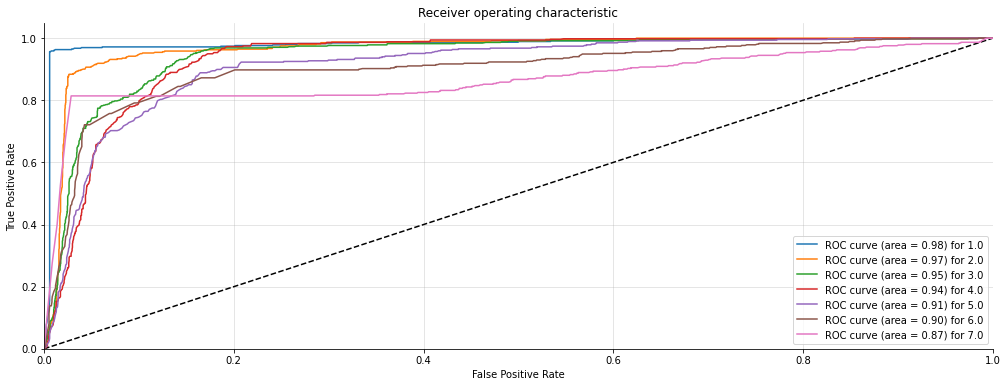

For column: complicated<==>easy
[15:25:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:26] WARNING: C:/Users/Administr

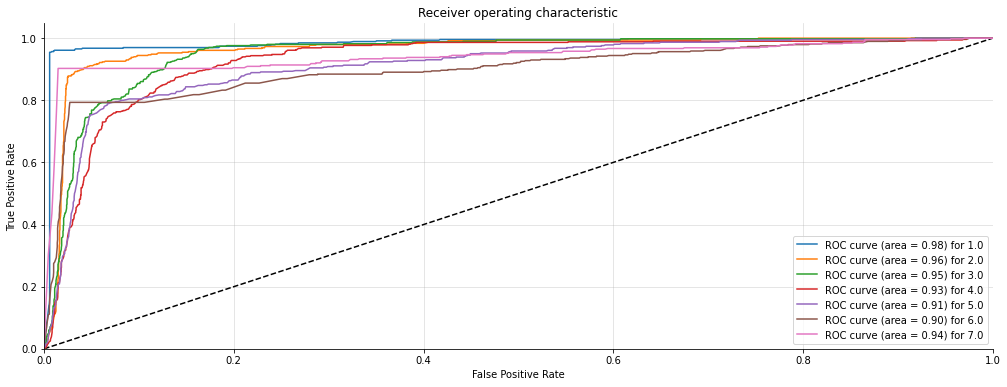

For column: inefficient<==>efficient
[15:25:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:28] WARNING: C:/Users/Admi

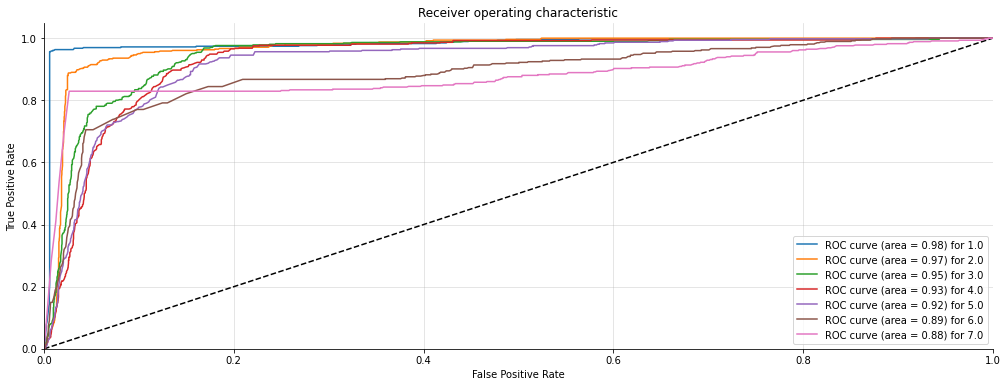

For column:  confusing<==>clear
[15:25:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:30] WARNING: C:/Users/Administr

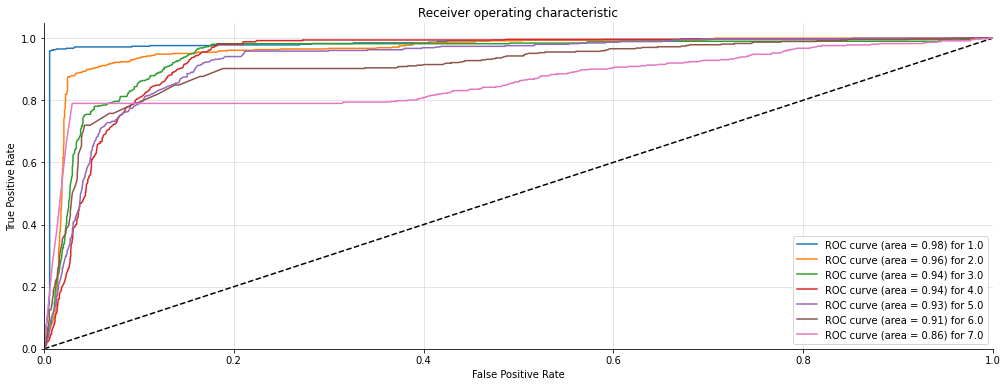

For column: boring<==>exciting
[15:25:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:32] WARNING: C:/Users/Administra

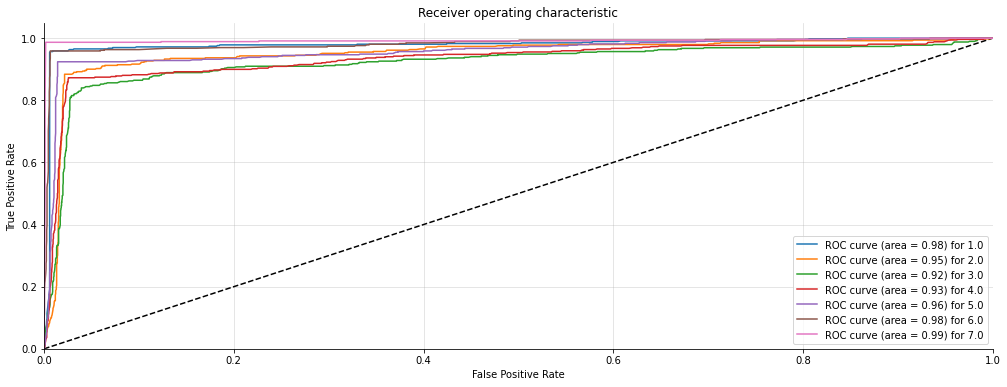

For column: not interesting<==>interesting
[15:25:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:34] WARNING: C:/User

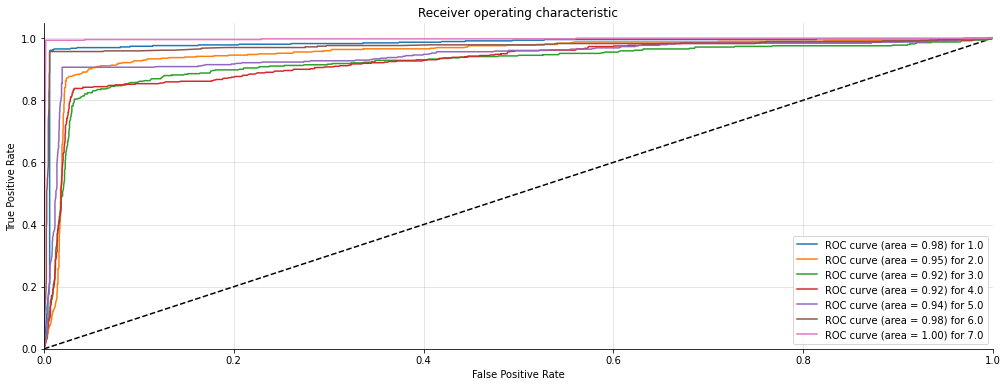

For column: conventional<==>inventive
[15:25:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:37] WARNING: C:/Users/Adm

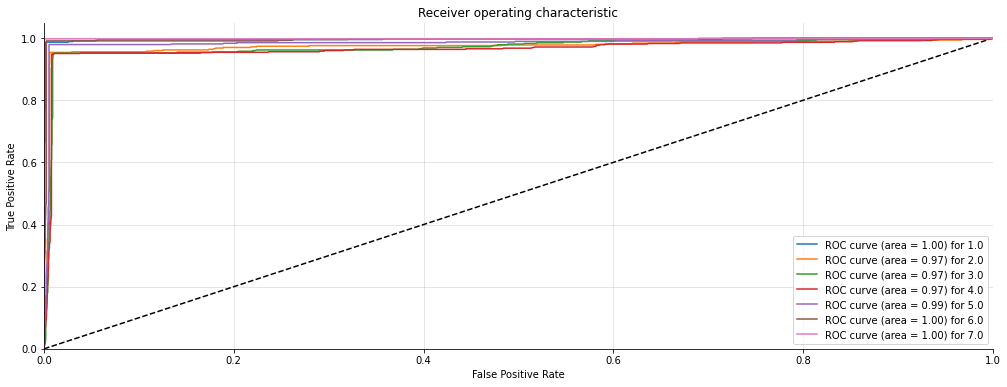

For column: usual<==>leading edge
[15:25:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:40] WARNING: C:/Users/Adminis

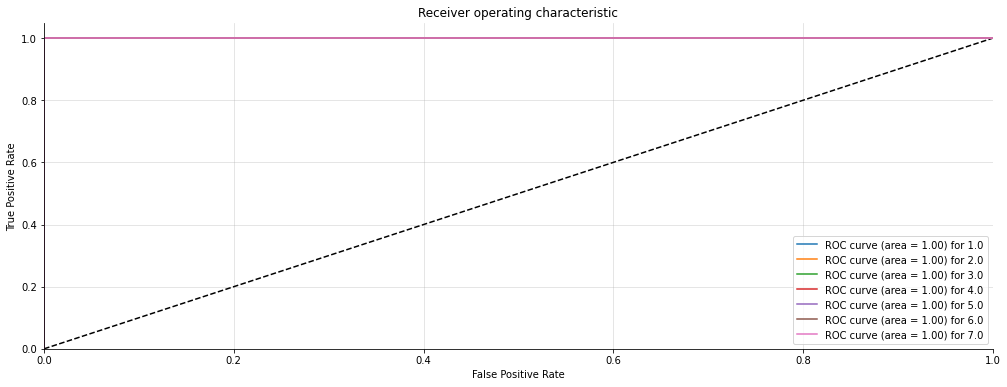

In [54]:
from sklearn.base import clone

acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        self.max_class = max(self.unique_class)
        self.min_class = min(self.unique_class)
        if self.unique_class.shape[0] > 2:
            # print(self.unique_class.shape[0]) # Uncomment to debug
            for i in range(self.unique_class.shape[0]):
                # for each k ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                
                
                clf.fit(X, binary_y)
                self.clfs[i + self.min_class] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        # print(self.clfs) # Uncomment to debug
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1) + self.min_class

def OrdinalModel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    clf = OrdinalClassifier(XGBClassifier()) # Using XGB as the placeholder model 
    clf.fit(X_train, y_train)

    # predictions over test set
    predictions = clf.predict(X_test)
    print((classification_report(y_test, predictions)))

    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    aucscore.append(score_auc(y_test,predictions))

    plot_multiclass_roc(clf, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  OrdinalModel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))
  #break # Uncomment to debug

In [55]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE -score :{}".format(np.mean(rms)))
print("average AUC score:{}".format(np.mean(aucscore)))
metric_df['OrdinalModel'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.86484375
average Precision :0.8646648408761268
average Recall :0.86484375
average F1 -score :0.8646906950394502
average RMSE -score :0.5980219522335155
average AUC score:0.9209596967563743


# 4. Other Deep Learning Model(s)

## 4.1. Bidirectional LSTM

In [37]:
## Callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
  "model_checkpoints", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

## Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(64, activation='relu', 
                          
                          # Prevent overfitting
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), 

                          # Ensuring consistent outputs and not run into potential local optima
                          # Avoid initializing standard normal (mean = 0, std = 1) to reach faster convergence and less initial loss.
                          kernel_initializer=tf.keras.initializers.RandomNormal(seed=42)
                          
                          ),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='linear')
])
LSTM_model.summary()

LSTM_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer= opt, metrics=[rmse])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          128000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 520       
Total params: 202,824
Trainable params: 202,824
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_split=0.2, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=1)

Epoch 1/100
21/21 [==============================] - 7s 160ms/step - loss: 17.5097 - rmse: 3.6755 - val_loss: 6.6618 - val_rmse: 2.2643
Epoch 2/100
21/21 [==============================] - 2s 88ms/step - loss: 5.9494 - rmse: 2.2314 - val_loss: 4.2784 - val_rmse: 1.8010
Epoch 3/100
21/21 [==============================] - 2s 97ms/step - loss: 5.1911 - rmse: 2.0563 - val_loss: 4.0337 - val_rmse: 1.7452
Epoch 4/100
21/21 [==============================] - 2s 89ms/step - loss: 4.9644 - rmse: 2.0029 - val_loss: 3.9618 - val_rmse: 1.7271
Epoch 5/100
21/21 [==============================] - 2s 86ms/step - loss: 4.7885 - rmse: 1.9592 - val_loss: 3.8729 - val_rmse: 1.7078
Epoch 6/100
21/21 [==============================] - 2s 91ms/step - loss: 4.6140 - rmse: 1.9195 - val_loss: 3.7041 - val_rmse: 1.6686
Epoch 7/100
21/21 [==============================] - 2s 79ms/step - loss: 4.2687 - rmse: 1.8331 - val_loss: 3.1753 - val_rmse: 1.5323
Epoch 8/100
21/21 [==============================] - 1s 67ms

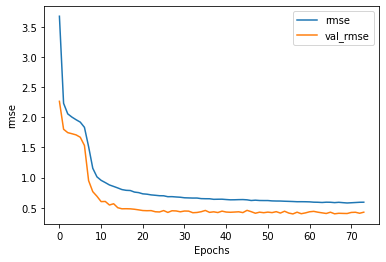

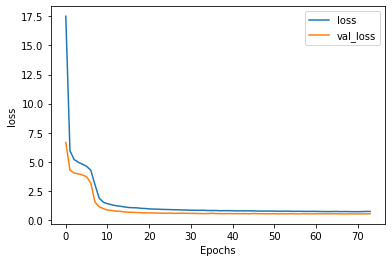

In [39]:
plot_graphs(history, "rmse")
plot_graphs(history, "loss")

# Result

In [40]:
LSTM_y_pred = LSTM_model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test_flattened[:10])
print("Predicted labels:",LSTM_y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test_flattened, LSTM_y_classified))

First ten examples of the test set:
Truth labels: [2. 1. 2. 1. 4. 3. 4. 3. 3. 7.]
Predicted labels: [2, 1, 3, 1, 4, 4, 4, 3, 4, 1]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.97      0.92      0.95      3691
         2.0       0.83      0.75      0.79      3921
         3.0       0.71      0.78      0.75      3952
         4.0       0.77      0.81      0.79      4161
         5.0       0.79      0.81      0.80      3786
         6.0       0.87      0.83      0.85      3748
         7.0       0.92      0.91      0.92      3621

    accuracy                           0.83     26880
   macro avg       0.84      0.83      0.83     26880
weighted avg       0.83      0.83      0.83     26880



## 4.2. BERT [deprecated]

In [41]:
"""!pip install -q -U tensorflow-text
!pip install -q tf-models-official
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

to_handle = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
to_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_model = hub.KerasLayer(to_preprocess)

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_model(text_test)

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(to_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(to_handle, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
print(f'Training model with {to_handle}')
history = classifier_model.fit(X_train, y_train)"""

"!pip install -q -U tensorflow-text\n!pip install -q tf-models-official\nimport tensorflow_hub as hub\nimport tensorflow_text as text\nfrom official.nlp import optimization  # to create AdamW optimizer\n\nto_handle = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'\nto_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'\nbert_model = hub.KerasLayer(to_preprocess)\n\ntext_test = ['this is such an amazing movie!']\ntext_preprocessed = bert_model(text_test)\n\ndef build_classifier_model():\n  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')\n  preprocessing_layer = hub.KerasLayer(to_preprocess, name='preprocessing')\n  encoder_inputs = preprocessing_layer(text_input)\n  encoder = hub.KerasLayer(to_handle, trainable=True, name='BERT_encoder')\n  outputs = encoder(encoder_inputs)\n  net = outputs['pooled_output']\n  net = tf.keras.layers.Dropout(0.1)(net)\n  net = tf.keras.layers.Dense(1, activation=None, name='classifi

# 4.3 RBFN

In [42]:

from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np

In [43]:
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        print("done")
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

from keras.initializers import Initializer
from sklearn.cluster import KMeans


class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_


In [44]:
import numpy as np, pandas as pd
from keras.models import Sequential 
from keras.layers.core import Dense
from keras.layers import Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [45]:
model = Sequential()
rbflayer = RBFLayer(100,
                        initializer=InitCentersKMeans(X_train),
                        betas=3.0,
                        input_shape=(X_train.shape[1],))
model.add(rbflayer)
model.add(Dense(8))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error',
                  optimizer='adam', metrics=['accuracy'])
model.build(X_train.shape)
print(model.summary())
history1 = model.fit(X_train, y_train, epochs=100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (13440, 100)              2100      
_________________________________________________________________
dense (Dense)                (13440, 8)                808       
_________________________________________________________________
activation (Activation)      (13440, 8)                0         
Total params: 2,908
Trainable params: 2,908
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
420/420 [==============================] - 12s 832us/step - loss: 19.2153 - accuracy: 0.0540
Epoch 2/100
420/420 [==============================] - 0s 826us/step - loss: 16.3288 - accuracy: 0.0447
Epoch 3/100
420/420 [==============================] - 0s 820us/step - loss: 13.5194 - accuracy: 0.0446
Epoch 4/100
420/420 [==============================] - 0s 821us/st

In [46]:
y_train.shape

(13440, 8)

In [47]:
LSTM_y_pred = model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test[:10])
print("Predicted labels:",LSTM_y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test.flatten(order='F'), LSTM_y_classified))

First ten examples of the test set:
Truth labels: [[2. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [4. 4. 4. 4. 5. 5. 5. 5.]
 [3. 3. 3. 3. 3. 3. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 4. 4.]
 [7. 7. 7. 7. 2. 2. 1. 1.]]
Predicted labels: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      3691
         2.0       0.00      0.00      0.00      3921
         3.0       0.00      0.00      0.00      3952
         4.0       0.16      0.98      0.28      4161
         5.0       0.78      0.07      0.12      3786
         6.0       0.92      0.09      0.16      3748
         7.0       0.93      0.17      0.28      3621

    accuracy                           0.20     26880
   macro avg       0.40      0.19      0.12     26880
weighted avg       0.39      0.20      0.12     268

In [48]:
from sklearn.metrics import classification_report

In [49]:
X_test.shape

(3360, 20)

In [50]:
y_test.shape

(3360, 8)

# 4.4 Multiclass Logistic regression

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.21      0.50      0.30       462
         2.0       0.20      0.14      0.17       482
         3.0       0.25      0.08      0.12       510
         4.0       0.25      0.16      0.19       517
         5.0       0.25      0.12      0.16       467
         6.0       0.21      0.16      0.18       470
         7.0       0.47      0.85      0.60       452

    accuracy                           0.28      3360
   macro avg       0.26      0.29      0.25      3360
weighted avg       0.26      0.28      0.24      3360

Confusion Matrix: 
 [[233  49  13  26  21  58  62]
 [197  69  30  47  22  51  66]
 [138  72  40  70  44  69  77]
 [170  66  29  82  59  44  67]
 [198  36  18  66  57  56  36]
 [141  49  21  35  19  77 128]
 [ 30   8   8   4   4  15 383]]
Accuracy Score : 0.2800595238095238
Precision Score : 0.2607957496539398
Recall Score : 0.2800595238095238
F1 Score : 0.2421869

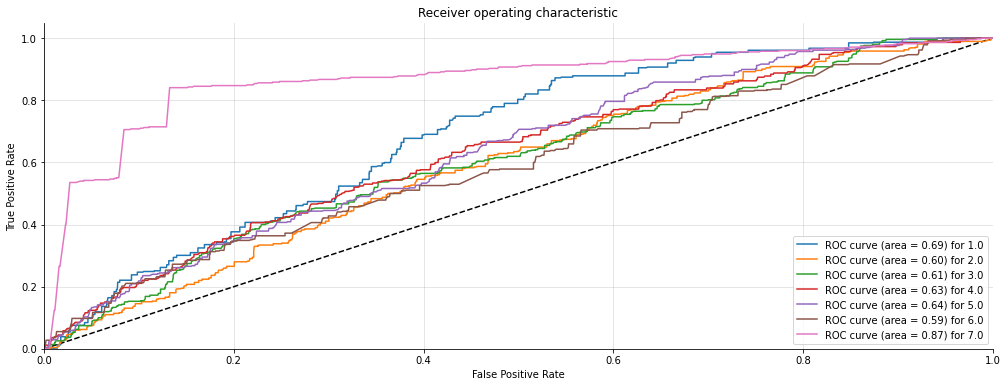

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.29      0.27      0.28       463
         2.0       0.17      0.13      0.15       485
         3.0       0.19      0.08      0.11       501
         4.0       0.19      0.20      0.20       515
         5.0       0.21      0.19      0.20       460
         6.0       0.27      0.33      0.30       484
         7.0       0.51      0.92      0.66       452

    accuracy                           0.30      3360
   macro avg       0.26      0.30      0.27      3360
weighted avg       0.26      0.30      0.27      3360

Confusion Matrix: 
 [[124  53  16  75  50  75  70]
 [ 76  63  49  87  60  84  66]
 [ 47  60  40  96  89  98  71]
 [ 64  75  43 103  91  76  63]
 [ 62  68  20  99  86  95  30]
 [ 52  41  44  66  20 162  99]
 [  4   7   3  10   5   8 415]]
Accuracy Score : 0.2955357142857143
Precision Score : 0.258770885435736
Recall Score : 0.2955357142857143
F1 Score : 0.26503901545514

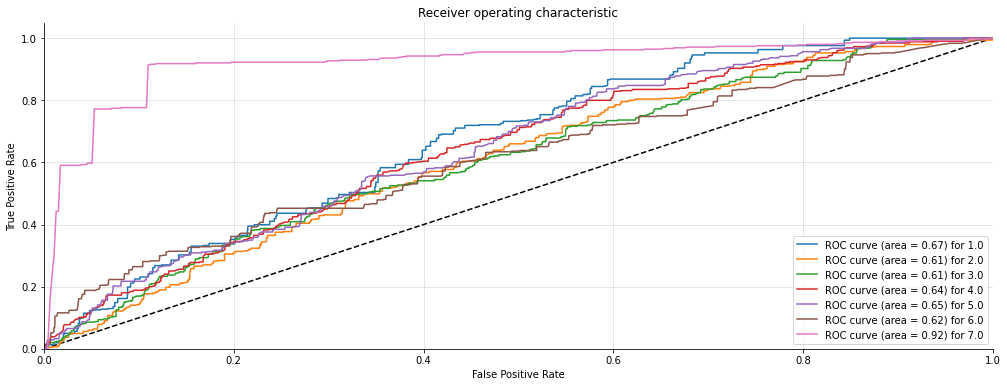

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.21      0.51      0.30       462
         2.0       0.20      0.16      0.18       482
         3.0       0.24      0.07      0.11       506
         4.0       0.25      0.13      0.17       526
         5.0       0.26      0.13      0.18       458
         6.0       0.25      0.20      0.22       475
         7.0       0.47      0.85      0.60       451

    accuracy                           0.28      3360
   macro avg       0.27      0.29      0.25      3360
weighted avg       0.27      0.28      0.25      3360

Confusion Matrix: 
 [[234  50  17  14  14  61  72]
 [196  78  21  46  21  53  67]
 [142  77  35  60  52  63  77]
 [175  72  29  69  68  47  66]
 [190  47  19  54  61  54  33]
 [144  52  19  28  13  96 123]
 [ 31   8   8   6   6   9 383]]
Accuracy Score : 0.2845238095238095
Precision Score : 0.26611657399949845
Recall Score : 0.2845238095238095
F1 Score : 0.2462097

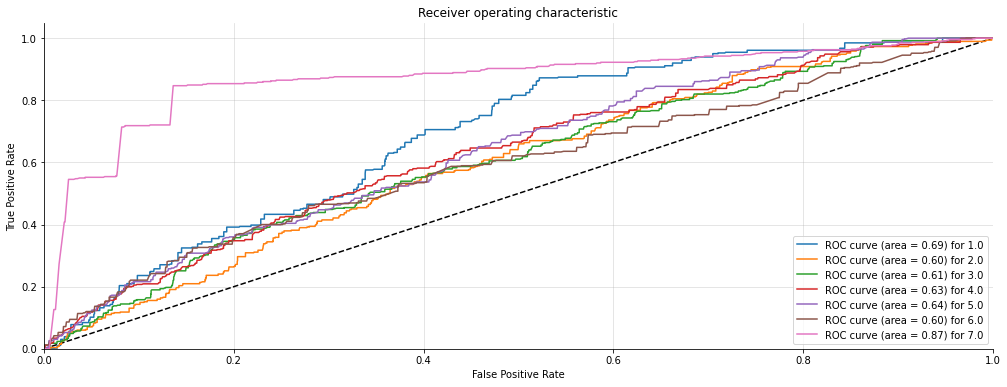

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.21      0.51      0.30       461
         2.0       0.20      0.15      0.17       488
         3.0       0.24      0.07      0.11       506
         4.0       0.25      0.13      0.18       516
         5.0       0.25      0.13      0.17       456
         6.0       0.24      0.20      0.22       471
         7.0       0.46      0.81      0.59       462

    accuracy                           0.28      3360
   macro avg       0.26      0.29      0.25      3360
weighted avg       0.26      0.28      0.24      3360

Confusion Matrix: 
 [[233  52  13  14  14  56  79]
 [201  75  26  42  27  52  65]
 [134  77  36  59  52  76  72]
 [176  68  29  69  68  42  64]
 [187  39  22  54  61  61  32]
 [136  49  18  25  16  95 132]
 [ 36  14   8   9   4  16 375]]
Accuracy Score : 0.28095238095238095
Precision Score : 0.26335950982032125
Recall Score : 0.28095238095238095
F1 Score : 0.2443997263

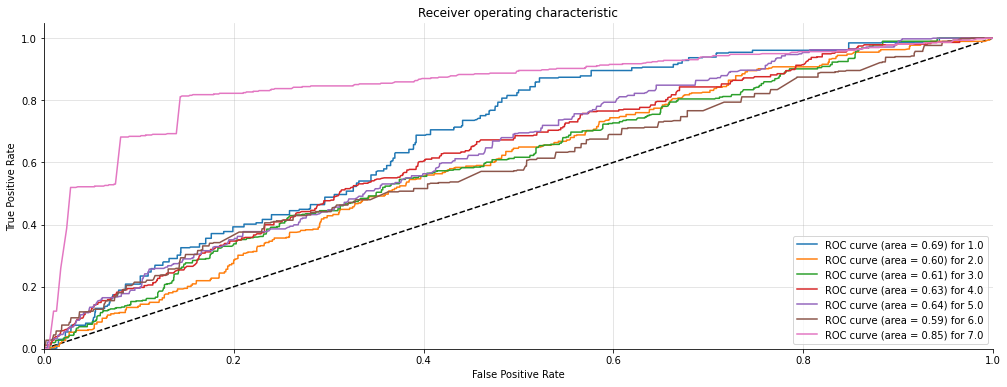

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.25      0.17      0.20       463
         2.0       0.22      0.14      0.17       491
         3.0       0.19      0.11      0.14       487
         4.0       0.21      0.20      0.21       518
         5.0       0.23      0.29      0.25       487
         6.0       0.29      0.42      0.34       462
         7.0       0.66      0.99      0.79       452

    accuracy                           0.32      3360
   macro avg       0.29      0.33      0.30      3360
weighted avg       0.29      0.32      0.29      3360

Confusion Matrix: 
 [[ 79  48  36  83  60 103  54]
 [ 63  68  54  90  87  89  40]
 [ 37  47  52  60 149  97  45]
 [ 40  59  42 106 142  98  31]
 [ 46  46  49  97 139  86  24]
 [ 55  41  48  58  29 194  37]
 [  1   1   0   2   0   1 447]]
Accuracy Score : 0.3229166666666667
Precision Score : 0.2876045085732315
Recall Score : 0.3229166666666667
F1 Score : 0.29494709424549

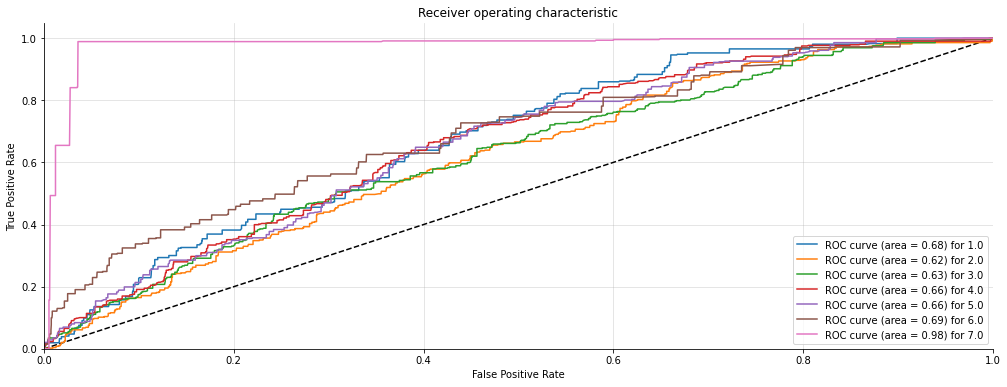

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.23      0.18      0.20       461
         2.0       0.21      0.11      0.14       495
         3.0       0.15      0.09      0.12       490
         4.0       0.23      0.24      0.24       519
         5.0       0.22      0.26      0.24       481
         6.0       0.27      0.38      0.32       465
         7.0       0.64      1.00      0.78       449

    accuracy                           0.31      3360
   macro avg       0.28      0.32      0.29      3360
weighted avg       0.28      0.31      0.28      3360

Confusion Matrix: 
 [[ 81  37  41  84  61 104  53]
 [ 68  54  67  94  85  85  42]
 [ 41  44  46  67 145  98  49]
 [ 45  47  43 123 134  93  34]
 [ 47  39  51 103 125  92  24]
 [ 62  40  54  55  26 179  49]
 [  1   0   0   0   0   1 447]]
Accuracy Score : 0.31398809523809523
Precision Score : 0.2756643730017237
Recall Score : 0.31398809523809523
F1 Score : 0.

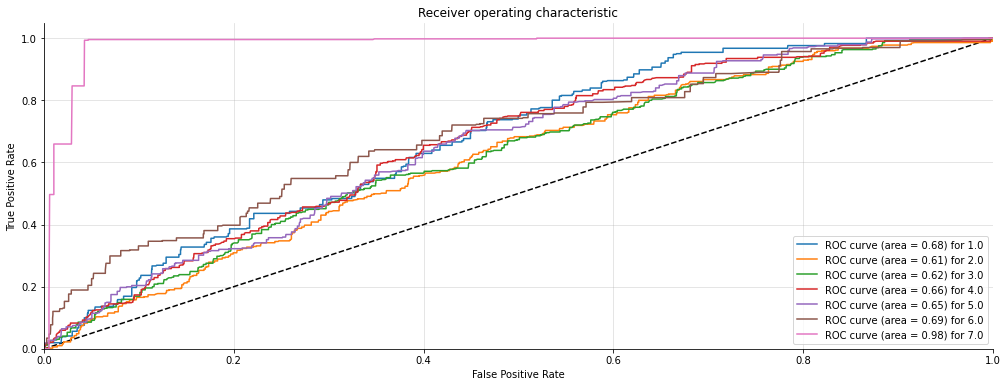

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.26      0.18      0.21       460
         2.0       0.22      0.14      0.17       502
         3.0       0.15      0.09      0.12       474
         4.0       0.24      0.23      0.23       527
         5.0       0.25      0.30      0.27       486
         6.0       0.30      0.44      0.36       459
         7.0       0.69      1.00      0.82       452

    accuracy                           0.33      3360
   macro avg       0.30      0.34      0.31      3360
weighted avg       0.30      0.33      0.31      3360

Confusion Matrix: 
 [[ 82  59  45  69  64  97  44]
 [ 68  71  59 103  79  87  35]
 [ 31  53  45  61 149  92  43]
 [ 43  46  45 122 130 111  30]
 [ 38  48  44 107 146  78  25]
 [ 54  49  56  51  22 201  26]
 [  0   0   0   1   0   0 451]]
Accuracy Score : 0.3327380952380952
Precision Score : 0.2966746250265603
Recall Score : 0.3327380952380952
F1 Score : 0.3056287

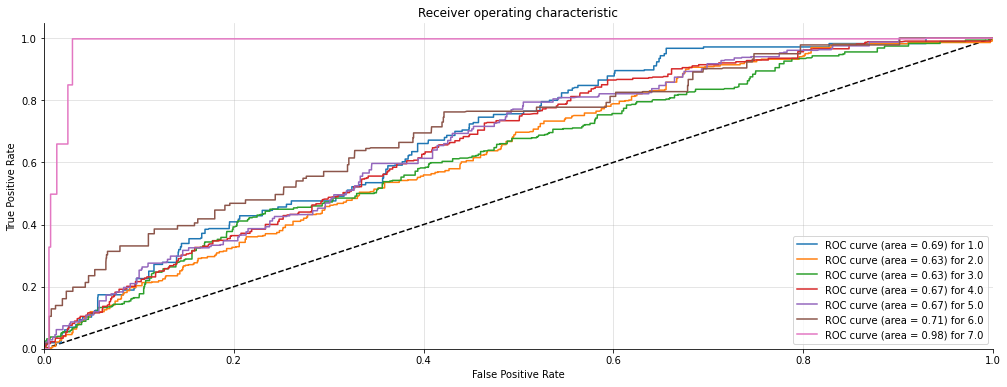

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.27      0.18      0.21       459
         2.0       0.21      0.14      0.17       496
         3.0       0.20      0.14      0.16       478
         4.0       0.26      0.25      0.26       523
         5.0       0.23      0.29      0.25       491
         6.0       0.32      0.45      0.37       462
         7.0       0.71      1.00      0.83       451

    accuracy                           0.34      3360
   macro avg       0.31      0.35      0.32      3360
weighted avg       0.31      0.34      0.32      3360

Confusion Matrix: 
 [[ 82  60  49  61  72  91  44]
 [ 56  71  65  98  91  81  34]
 [ 28  50  65  58 147  91  39]
 [ 40  51  47 129 135  99  22]
 [ 37  62  45 100 141  85  21]
 [ 65  41  52  41  29 207  27]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.3410714285714286
Precision Score : 0.3094232160267994
Recall Score : 0.3410714285714286
F1 Score : 0.31672902179

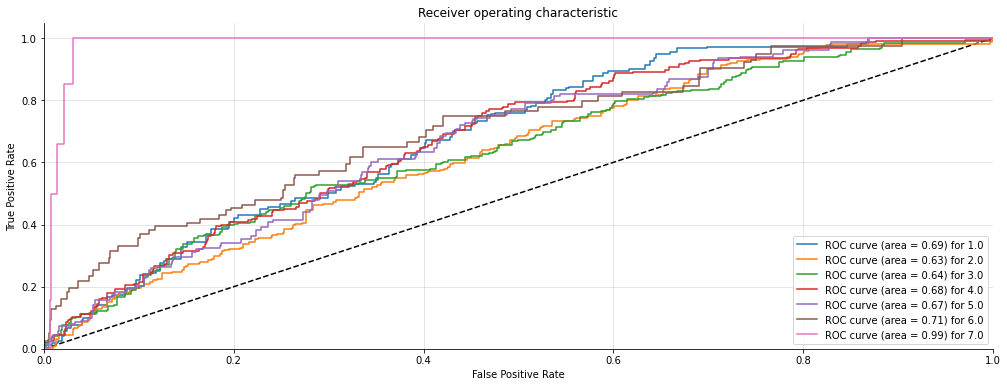

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def Logistic(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs')   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  Logistic(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [57]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE :{}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['LogisticModel'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.3064732142857143
average Precision :0.27730118019222627
average Recall :0.3064732142857143
average F1 -score :0.27492925746301017
average RMSE :2.4478175339745283
average AUC score 0.5957460039585816


# 4.5 Neural network - classifier

In [53]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initializer = tf.keras.initializers.RandomNormal(seed=1) # Reproducibility

model = Sequential(name="classifier_NN")
model.add(tf.keras.Input(shape=(X_train.shape[1],))) # Automatically detect features as input nodes
model.add(layers.Dense(512, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(64, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(8)) # output layer
opt = tf.keras.optimizers.Adam(learning_rate = 0.0003)
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[rmse], optimizer = opt)
model.summary()

Model: "classifier_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               10752     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 128)             

Epoch 1/150
588/588 - 1s - loss: 4.9029 - rmse: 1.8389 - val_loss: 2.6989 - val_rmse: 1.3072
Epoch 2/150
588/588 - 1s - loss: 2.5684 - rmse: 1.3253 - val_loss: 1.7423 - val_rmse: 1.0281
Epoch 3/150
588/588 - 1s - loss: 1.8317 - rmse: 1.1216 - val_loss: 1.3978 - val_rmse: 0.9282
Epoch 4/150
588/588 - 1s - loss: 1.5918 - rmse: 1.0397 - val_loss: 1.2404 - val_rmse: 0.8689
Epoch 5/150
588/588 - 1s - loss: 1.3769 - rmse: 0.9562 - val_loss: 1.0227 - val_rmse: 0.7880
Epoch 6/150
588/588 - 1s - loss: 1.2576 - rmse: 0.9007 - val_loss: 1.1905 - val_rmse: 0.8590
Epoch 7/150
588/588 - 1s - loss: 1.1621 - rmse: 0.8550 - val_loss: 1.2758 - val_rmse: 0.9235
Epoch 8/150
588/588 - 1s - loss: 1.0983 - rmse: 0.8268 - val_loss: 0.8128 - val_rmse: 0.6846
Epoch 9/150
588/588 - 1s - loss: 1.0157 - rmse: 0.7806 - val_loss: 0.8471 - val_rmse: 0.7204
Epoch 10/150
588/588 - 1s - loss: 1.0163 - rmse: 0.7769 - val_loss: 1.1363 - val_rmse: 0.8576
Epoch 11/150
588/588 - 1s - loss: 0.9566 - rmse: 0.7481 - val_loss: 0

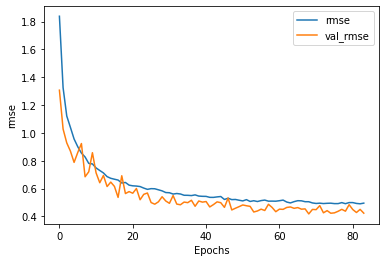

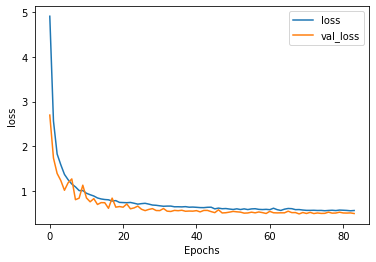

In [54]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(X_train, y_train, epochs=150, batch_size = 16, validation_split=0.3, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=2)

plot_graphs(history, "rmse")
plot_graphs(history, "loss")

In [55]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 2s 647us/step - loss: 0.5241 - rmse: 0.4282
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 52.41%
rmse: 42.82%


# 4.6 LSTM 

In [56]:
## Callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
  "model_checkpoints", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

## Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(4000, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(64, activation='relu', 
                          
                          # Prevent overfitting
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), 

                          # Ensuring consistent outputs and not run into potential local optima
                          # Avoid initializing standard normal (mean = 0, std = 1) to reach faster convergence and less initial loss.
                          kernel_initializer=tf.keras.initializers.RandomNormal(seed=42)
                          
                          ),
     
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='linear')
])
LSTM_model.summary()

LSTM_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer= opt, metrics=[rmse])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         512000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 520       
Total params: 792,136
Trainable params: 792,136
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_split=0.2, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=1)

Epoch 1/100
21/21 [==============================] - 6s 223ms/step - loss: 13.8779 - rmse: 3.2254 - val_loss: 4.4529 - val_rmse: 1.8556
Epoch 2/100
21/21 [==============================] - 4s 214ms/step - loss: 4.7655 - rmse: 1.9181 - val_loss: 3.4656 - val_rmse: 1.5767
Epoch 3/100
21/21 [==============================] - 5s 217ms/step - loss: 3.0725 - rmse: 1.4657 - val_loss: 1.6354 - val_rmse: 0.9842
Epoch 4/100
21/21 [==============================] - 4s 212ms/step - loss: 1.8996 - rmse: 1.1331 - val_loss: 1.1521 - val_rmse: 0.7258
Epoch 5/100
21/21 [==============================] - 4s 209ms/step - loss: 1.5618 - rmse: 0.9960 - val_loss: 0.9765 - val_rmse: 0.6224
Epoch 6/100
21/21 [==============================] - 4s 211ms/step - loss: 1.3868 - rmse: 0.9204 - val_loss: 0.8906 - val_rmse: 0.5775
Epoch 7/100
21/21 [==============================] - 4s 212ms/step - loss: 1.2693 - rmse: 0.8685 - val_loss: 0.8541 - val_rmse: 0.5609
Epoch 8/100
21/21 [==============================] - 4

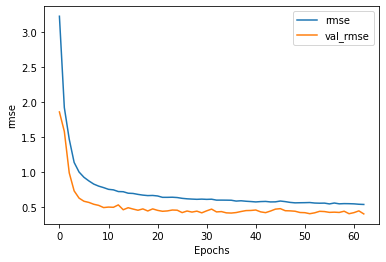

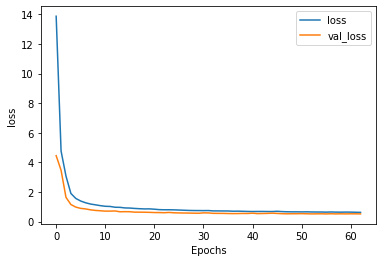

In [58]:
plot_graphs(history, "rmse")
plot_graphs(history, "loss")

In [59]:
scores = LSTM_model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 5s 1ms/step - loss: 0.5137 - rmse: 0.3935
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 51.37%
rmse: 39.35%


# 4.7 Ensemble

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# 4.7.1 Decison tree classifier

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.83      0.89      0.86       482
         3.0       0.74      0.75      0.74       510
         4.0       0.68      0.65      0.66       517
         5.0       0.66      0.65      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.77      3360
   macro avg       0.77      0.78      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  1 427  52   0   1   1   0]
 [  0  14 380 111   2   3   0]
 [  0   1  37 337 141   1   0]
 [  4   4  15  28 304 112   0]
 [  3  20   9  10   6 339  83]
 [ 10  26  21  12   9   6 368]]
Accuracy Score : 0.7729166666666667
Precision Score : 0.771760381976533
Recall Score : 0.7729166666666667
F1 Score : 0.77217868

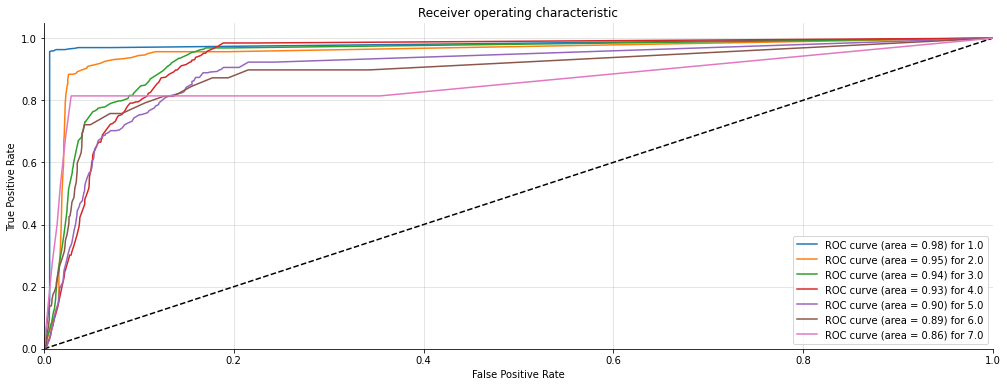

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.84      0.88      0.86       485
         3.0       0.74      0.75      0.75       501
         4.0       0.69      0.68      0.69       515
         5.0       0.71      0.73      0.72       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.81      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.81      0.81      0.81      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  1 428  52   0   1   3   0]
 [  0  13 374 112   2   0   0]
 [  0   3  40 348 122   2   0]
 [  3  13  15  23 336  70   0]
 [  5  17  16  14   5 384  43]
 [  9  18   6   4   5   2 408]]
Accuracy Score : 0.8095238095238095
Precision Score : 0.809491966192294
Recall Score : 0.8095238095238095
F1 Score : 0.80931792799411

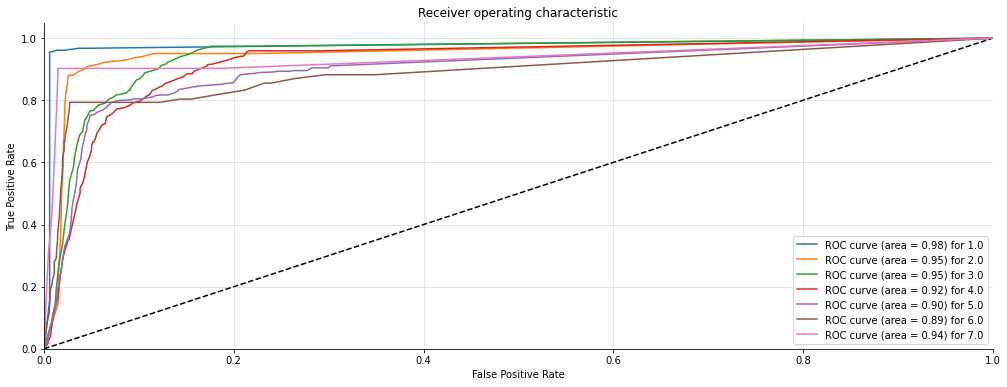

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.89      0.86       482
         3.0       0.74      0.75      0.74       506
         4.0       0.68      0.65      0.67       526
         5.0       0.66      0.66      0.66       458
         6.0       0.73      0.71      0.72       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.77      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  1 428  52   0   1   0   0]
 [  0  13 378 111   1   3   0]
 [  0   2  42 343 139   0   0]
 [  2   4   7  25 303 117   0]
 [  6  19  19  12   7 335  77]
 [  9  27  16  12   7   6 374]]
Accuracy Score : 0.774702380952381
Precision Score : 0.7735329313079256
Recall Score : 0.774702380952381
F1 Score : 0.7739259086

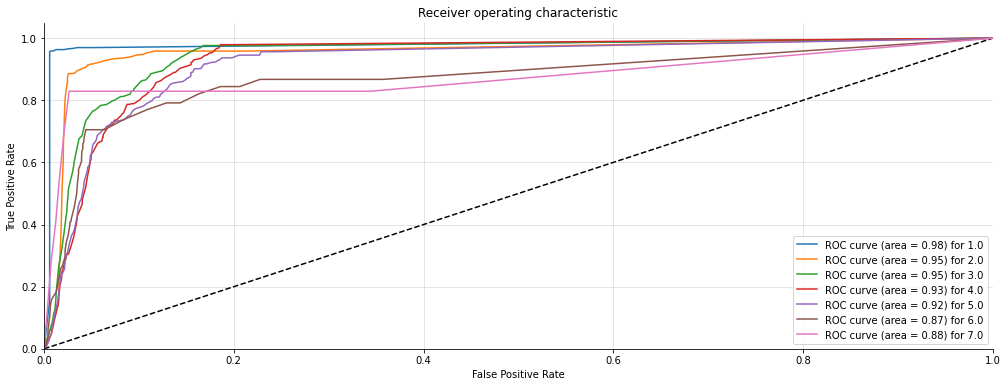

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.84      0.88      0.86       488
         3.0       0.75      0.74      0.74       506
         4.0       0.68      0.67      0.67       516
         5.0       0.67      0.68      0.67       456
         6.0       0.73      0.72      0.73       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  1 428  53   1   2   3   0]
 [  0  14 375 116   0   1   0]
 [  0   0  29 344 141   2   0]
 [  2   2   8  23 308 113   0]
 [  2  16  15  10   3 339  86]
 [ 13  33  23  15   9   4 365]]
Accuracy Score : 0.7741071428571429
Precision Score : 0.7737248638485457
Recall Score : 0.7741071428571429
F1 Score : 0.7738076801415

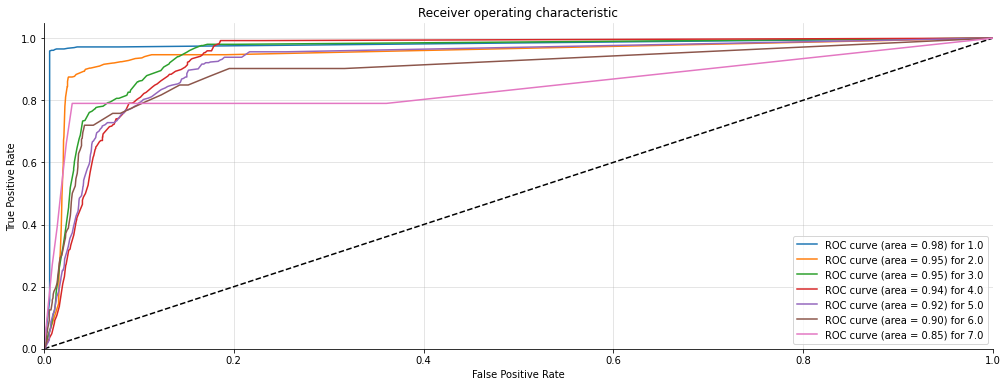

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.87       491
         3.0       0.83      0.81      0.82       487
         4.0       0.87      0.87      0.87       518
         5.0       0.92      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  6 433  47   1   1   3   0]
 [  7  24 396  58   2   0   0]
 [  3  15  17 450  32   1   0]
 [  1   5  11   9 450  11   0]
 [  1   4   3   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9107142857142857
Precision Score : 0.910665109593827
Recall Score : 0.9107142857142857
F1 Score : 0.910664250002280

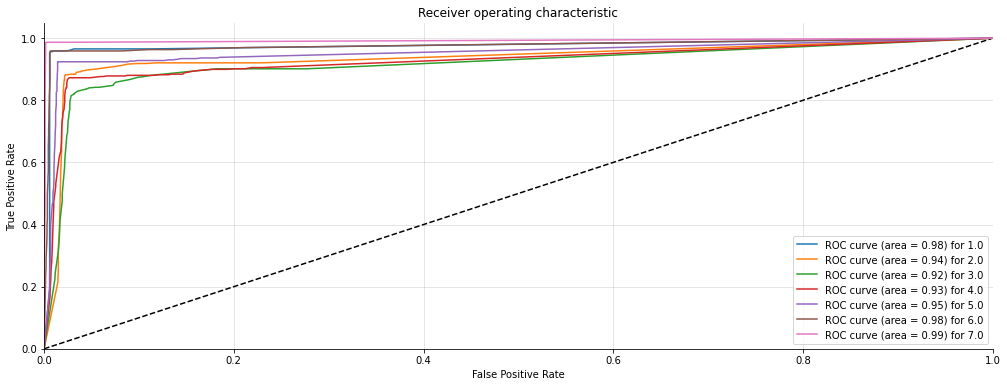

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.86      0.87      0.86       495
         3.0       0.81      0.79      0.80       490
         4.0       0.83      0.83      0.83       519
         5.0       0.89      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  6 431  51   1   2   4   0]
 [  7  26 387  69   0   1   0]
 [  3  18  19 432  47   0   0]
 [  1   7  11  15 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8985119047619048
Precision Score : 0.8982749727109632
Recall Score : 0.8985119047619048
F1 Score : 0.89

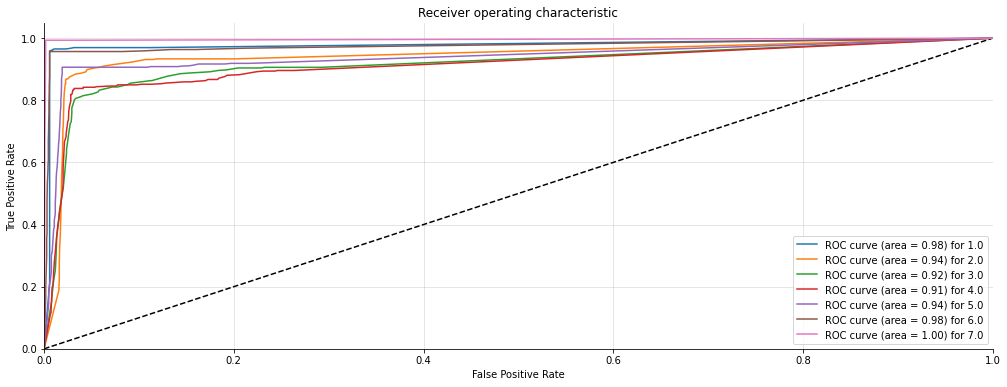

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.96      0.95      0.96       502
         3.0       0.94      0.95      0.95       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 479  15   2   1   0   0]
 [  0  12 449  13   0   0   0]
 [  0   1  12 500  10   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9714285714285714
Precision Score : 0.9714203087811575
Recall Score : 0.9714285714285714
F1 Score : 0.9714139

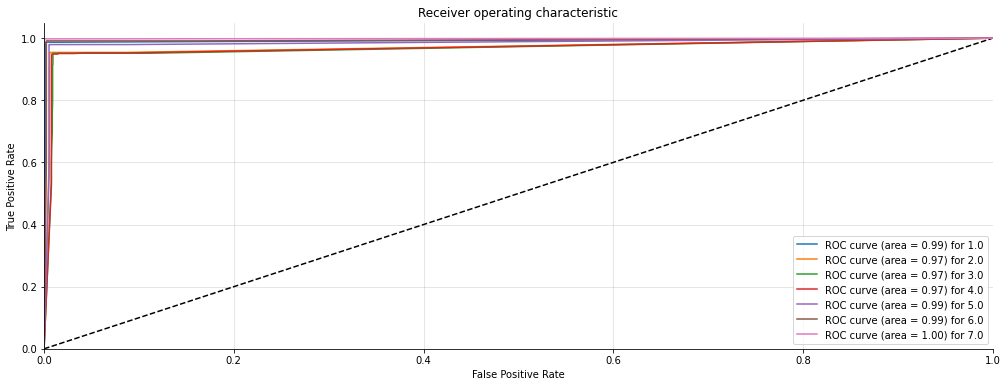

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


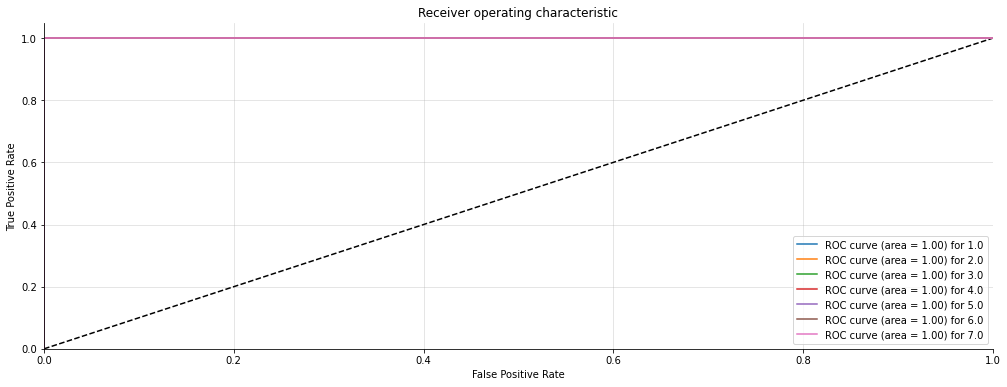

In [59]:
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def DTC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = DecisionTreeClassifier(max_depth=None, min_samples_split=2,
     random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    aucscore.append(score_auc(y_test,predictions))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))


    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  DTC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [60]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE :{}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['DecisionTreeclasssifier'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8639880952380953
average Precision :0.8636088168014058
average Recall :0.8639880952380953
average F1 -score :0.8637064365059823
average RMSE :0.5962687037331302
average AUC score 0.9204599724435056


# 4.7.2 Random forest classifier

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.85      0.88      0.86       482
         3.0       0.75      0.75      0.75       510
         4.0       0.68      0.66      0.67       517
         5.0       0.66      0.66      0.66       467
         6.0       0.73      0.72      0.73       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.77      0.78      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  0 425  52   0   1   1   3]
 [  0   7 383 113   2   3   2]
 [  0   1  32 341 142   1   0]
 [  4   4  15  25 307 112   0]
 [  3  19  10  10   6 339  83]
 [ 10  26  21  12   9   6 368]]
Accuracy Score : 0.7752976190476191
Precision Score : 0.7744789080792417
Recall Score : 0.7752976190476191
F1 Score : 0.7747995

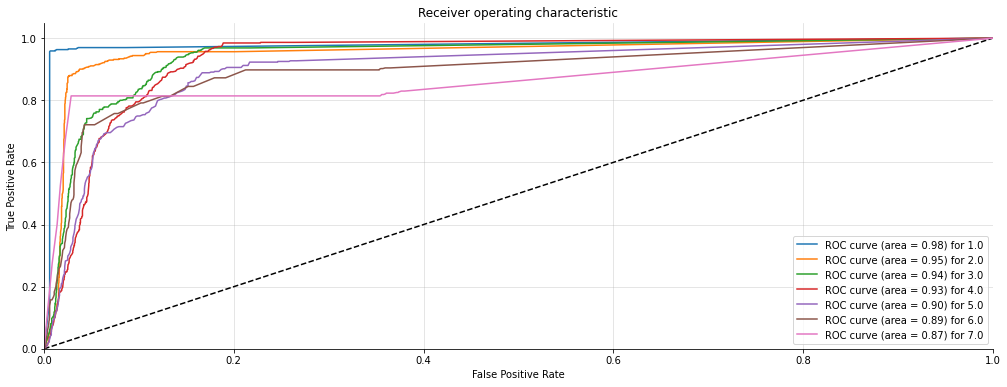

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.85      0.88      0.86       485
         3.0       0.76      0.75      0.76       501
         4.0       0.70      0.69      0.69       515
         5.0       0.71      0.74      0.72       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.81      3360
   macro avg       0.82      0.82      0.82      3360
weighted avg       0.81      0.81      0.81      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  0 426  52   2   2   3   0]
 [  0   7 378 114   2   0   0]
 [  0   3  33 353 124   2   0]
 [  3  13  15  19 340  70   0]
 [  5  17  16  14   5 384  43]
 [  9  18   6   4   5   2 408]]
Accuracy Score : 0.812797619047619
Precision Score : 0.8131589308016312
Recall Score : 0.812797619047619
F1 Score : 0.812821536724512

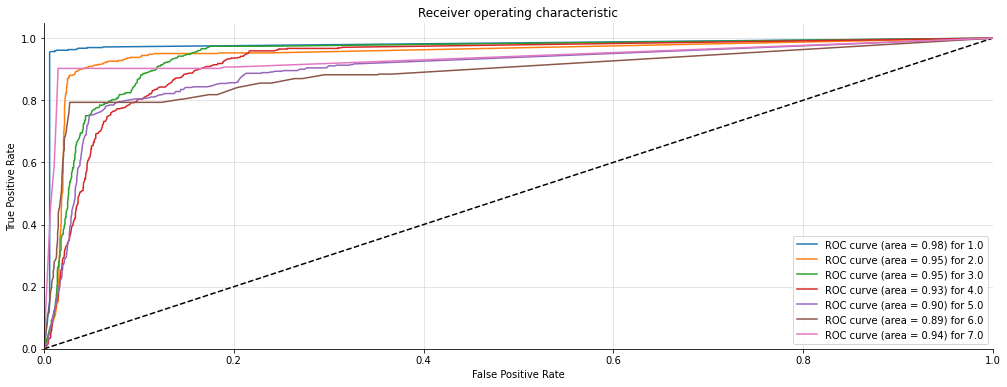

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.85      0.88      0.86       482
         3.0       0.74      0.75      0.75       506
         4.0       0.69      0.66      0.67       526
         5.0       0.66      0.67      0.67       458
         6.0       0.73      0.71      0.72       475
         7.0       0.82      0.83      0.82       451

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.78      0.78      0.78      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  0 426  52   0   1   0   3]
 [  0   7 380 113   1   3   2]
 [  0   2  37 347 140   0   0]
 [  2   4   7  22 306 117   0]
 [  6  19  19  12   7 335  77]
 [  9  27  16  12   7   6 374]]
Accuracy Score : 0.7767857142857143
Precision Score : 0.7758830491931181
Recall Score : 0.7767857142857143
F1 Score : 0.77620442

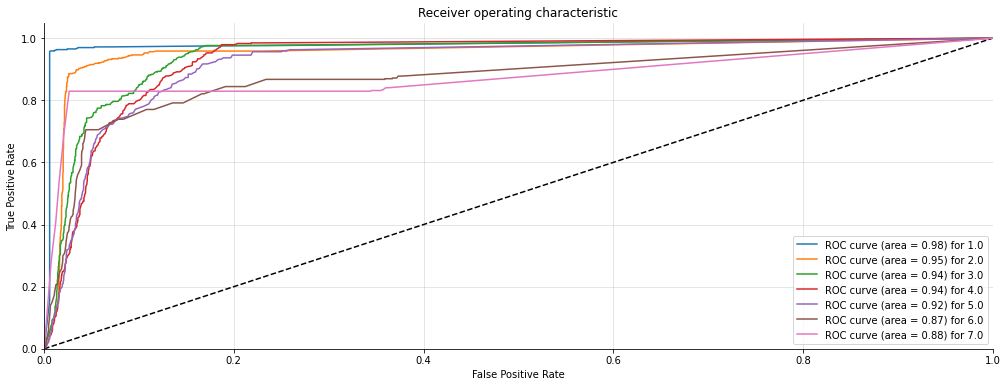

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.85      0.87      0.86       488
         3.0       0.76      0.75      0.75       506
         4.0       0.68      0.69      0.68       516
         5.0       0.67      0.68      0.67       456
         6.0       0.73      0.72      0.72       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.78      0.78      0.78      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  0 426  53   1   2   5   1]
 [  0   7 378 118   0   3   0]
 [  0   0  18 355 141   2   0]
 [  2   2   8  23 308 113   0]
 [  2  15  16  10   3 339  86]
 [ 13  33  23  15   9   4 365]]
Accuracy Score : 0.7776785714285714
Precision Score : 0.7778696216166151
Recall Score : 0.7776785714285714
F1 Score : 0.7777123306689

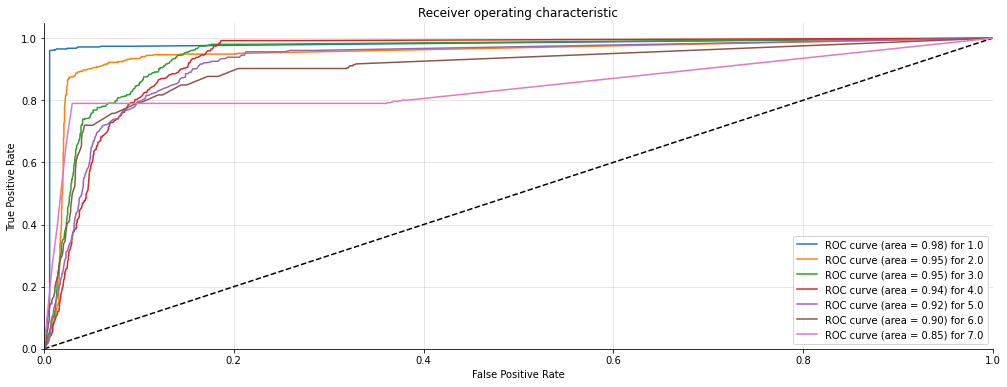

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.88       491
         3.0       0.83      0.81      0.82       487
         4.0       0.86      0.87      0.87       518
         5.0       0.91      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  5 433  47   1   2   3   0]
 [  7  23 395  60   2   0   0]
 [  3  15  17 450  32   1   0]
 [  1   5  11   9 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9104166666666667
Precision Score : 0.9103788324495029
Recall Score : 0.9104166666666667
F1 Score : 0.91037214364377

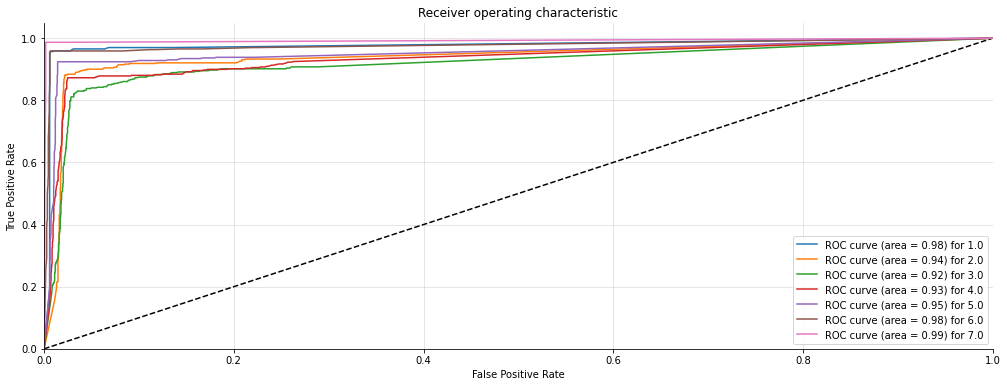

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.86      0.87      0.87       495
         3.0       0.81      0.79      0.80       490
         4.0       0.83      0.83      0.83       519
         5.0       0.89      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  5 431  51   1   3   4   0]
 [  7  25 386  71   0   1   0]
 [  3  17  20 432  47   0   0]
 [  1   7  11  15 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8982142857142857
Precision Score : 0.8980091863514463
Recall Score : 0.8982142857142857
F1 Score : 0.89

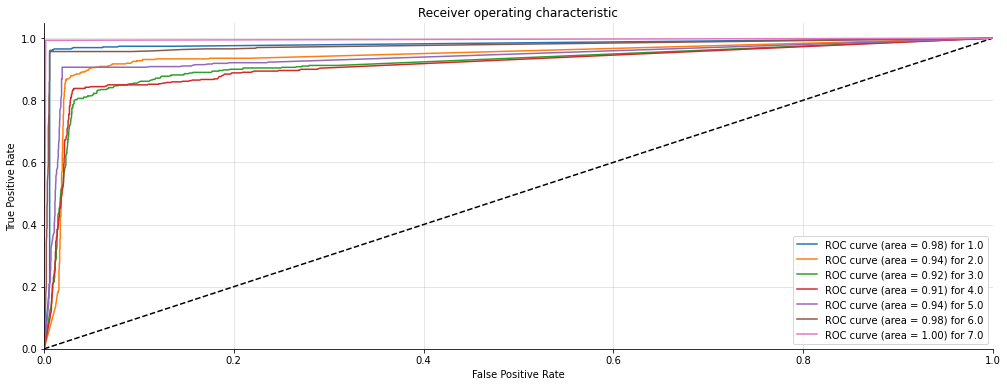

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.96      0.95      0.96       502
         3.0       0.94      0.95      0.95       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 479  15   2   1   0   0]
 [  0  12 449  13   0   0   0]
 [  0   1  12 500  10   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9714285714285714
Precision Score : 0.9714203087811575
Recall Score : 0.9714285714285714
F1 Score : 0.9714139

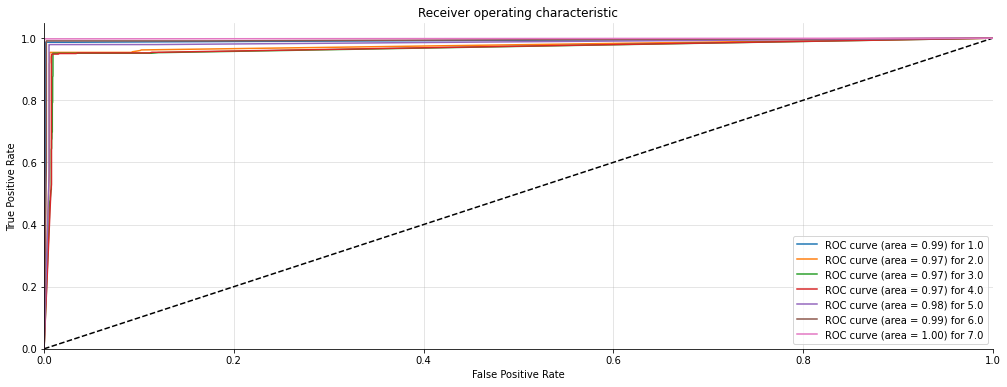

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


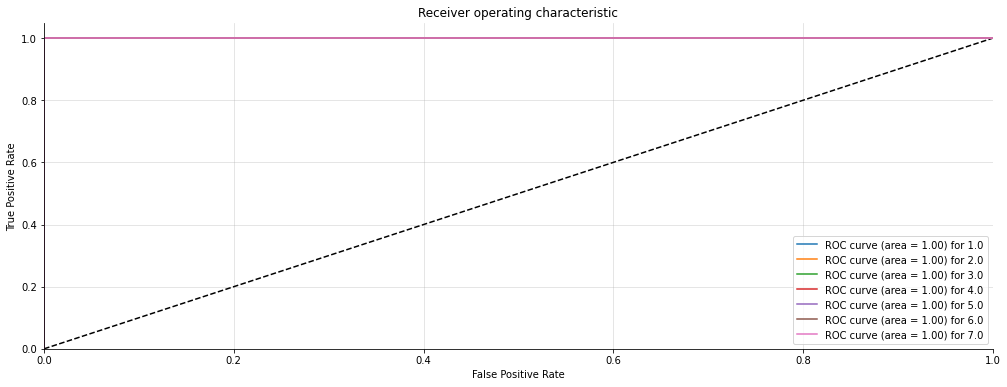

In [61]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def RFC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = RandomForestClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  RFC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [62]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['RandomForestClassifier'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8653273809523809
average Precision :0.865149854659089
average Recall :0.8653273809523809
average F1 -score :0.8651730927656748
average RMSE 0.601286935944773
average AUC score 0.9212486865412578


# 4.7.3 Extra Trees Classifier

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.83      0.89      0.86       482
         3.0       0.74      0.75      0.74       510
         4.0       0.68      0.65      0.66       517
         5.0       0.66      0.65      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.77      3360
   macro avg       0.77      0.78      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  1 427  52   0   1   1   0]
 [  0  14 380 111   2   3   0]
 [  0   1  37 337 141   1   0]
 [  4   4  15  28 304 112   0]
 [  3  20   9  10   6 339  83]
 [ 10  26  21  12   9   6 368]]
Accuracy Score : 0.7729166666666667
Precision Score : 0.771760381976533
Recall Score : 0.7729166666666667
F1 Score : 0.77217868

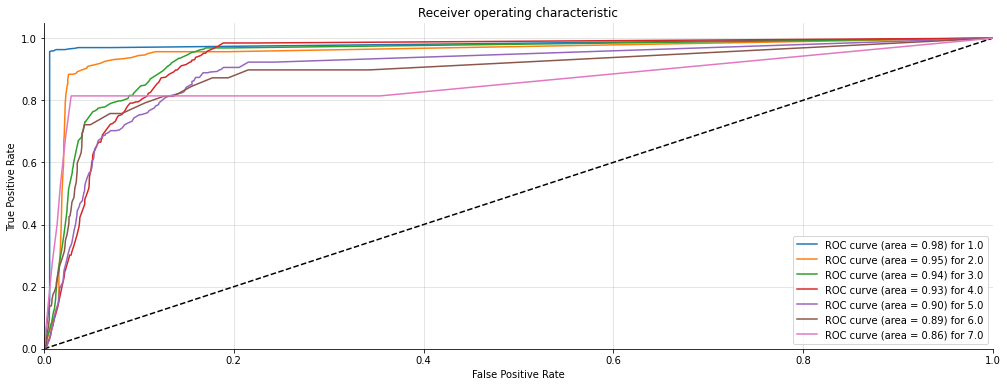

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.84      0.88      0.86       485
         3.0       0.74      0.75      0.75       501
         4.0       0.69      0.68      0.69       515
         5.0       0.71      0.73      0.72       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.81      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.81      0.81      0.81      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  1 428  52   0   1   3   0]
 [  0  13 374 112   2   0   0]
 [  0   3  40 348 122   2   0]
 [  3  13  15  23 336  70   0]
 [  5  17  16  14   5 384  43]
 [  9  18   6   4   5   2 408]]
Accuracy Score : 0.8095238095238095
Precision Score : 0.809491966192294
Recall Score : 0.8095238095238095
F1 Score : 0.80931792799411

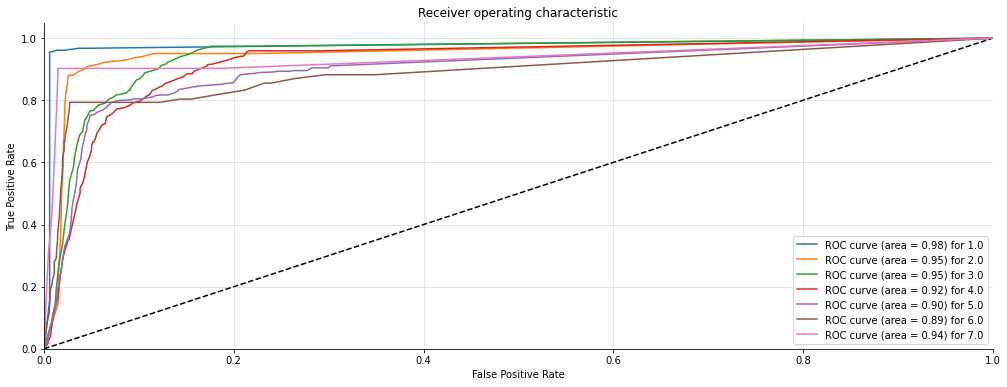

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.89      0.86       482
         3.0       0.74      0.75      0.74       506
         4.0       0.68      0.65      0.67       526
         5.0       0.66      0.66      0.66       458
         6.0       0.73      0.71      0.72       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.77      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  1 428  52   0   1   0   0]
 [  0  13 378 111   1   3   0]
 [  0   2  42 343 139   0   0]
 [  2   4   7  25 303 117   0]
 [  6  19  19  12   7 335  77]
 [  9  27  16  12   7   6 374]]
Accuracy Score : 0.774702380952381
Precision Score : 0.7735329313079256
Recall Score : 0.774702380952381
F1 Score : 0.7739259086

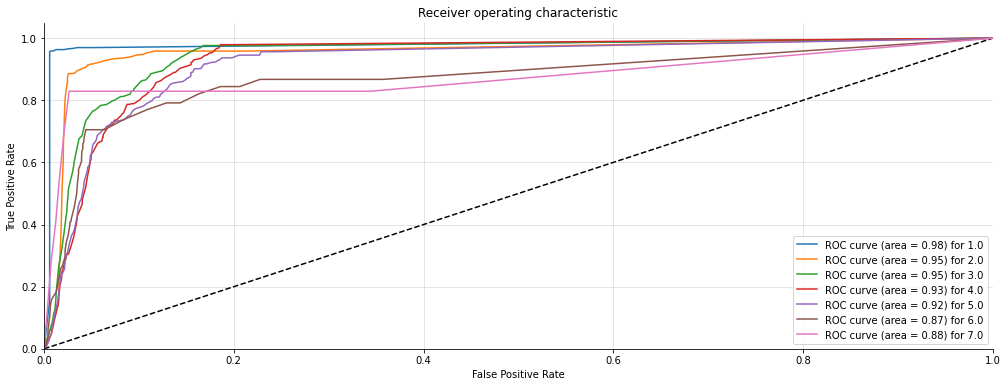

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.84      0.88      0.86       488
         3.0       0.75      0.74      0.74       506
         4.0       0.68      0.67      0.67       516
         5.0       0.67      0.68      0.67       456
         6.0       0.73      0.72      0.73       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  1 428  53   1   2   3   0]
 [  0  14 375 116   0   1   0]
 [  0   0  29 344 141   2   0]
 [  2   2   8  23 308 113   0]
 [  2  16  15  10   3 339  86]
 [ 13  33  23  15   9   4 365]]
Accuracy Score : 0.7741071428571429
Precision Score : 0.7737248638485457
Recall Score : 0.7741071428571429
F1 Score : 0.7738076801415

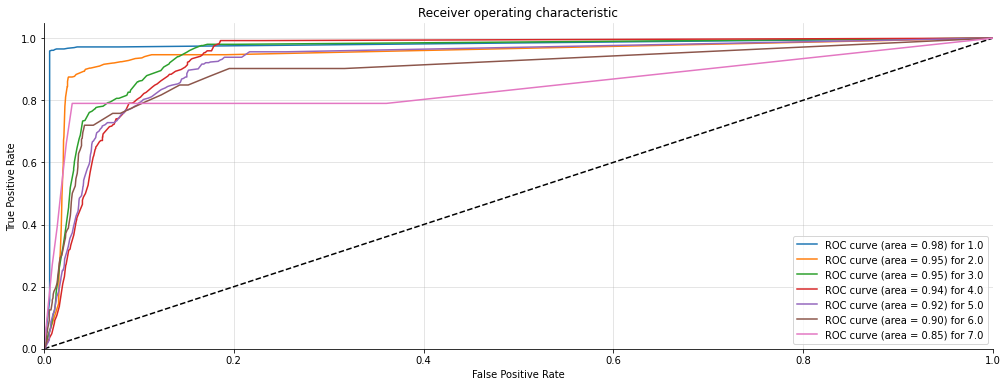

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.87       491
         3.0       0.83      0.81      0.82       487
         4.0       0.87      0.87      0.87       518
         5.0       0.92      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  6 433  47   1   1   3   0]
 [  7  24 396  58   2   0   0]
 [  3  15  17 450  32   1   0]
 [  1   5  11   9 450  11   0]
 [  1   4   3   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9107142857142857
Precision Score : 0.910665109593827
Recall Score : 0.9107142857142857
F1 Score : 0.910664250002280

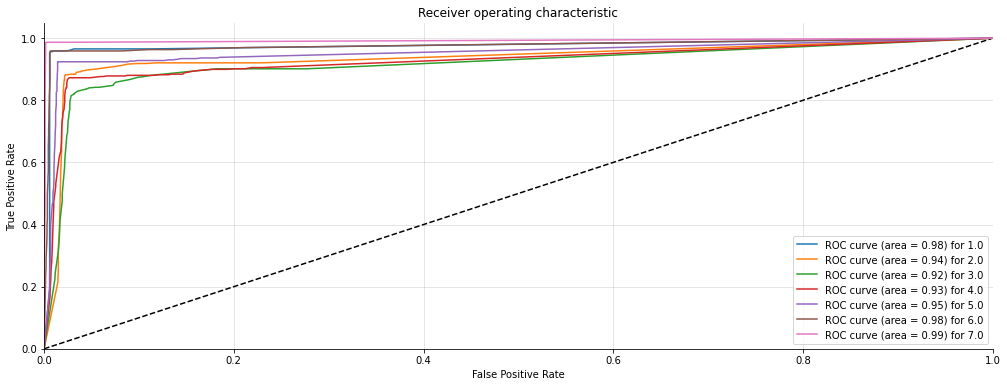

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.86      0.87      0.86       495
         3.0       0.81      0.79      0.80       490
         4.0       0.83      0.83      0.83       519
         5.0       0.89      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  6 431  51   1   2   4   0]
 [  7  26 387  69   0   1   0]
 [  3  18  19 432  47   0   0]
 [  1   7  11  15 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8985119047619048
Precision Score : 0.8982749727109632
Recall Score : 0.8985119047619048
F1 Score : 0.89

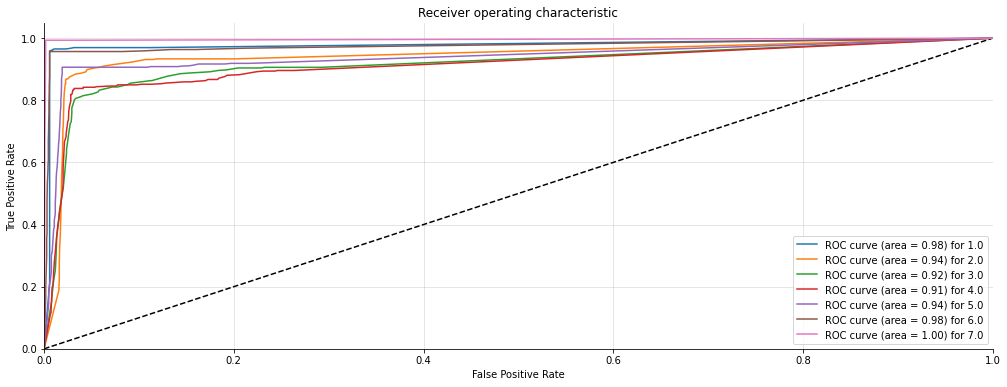

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.96      0.95      0.96       502
         3.0       0.94      0.95      0.95       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 479  15   2   1   0   0]
 [  0  12 449  13   0   0   0]
 [  0   1  12 500  10   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9714285714285714
Precision Score : 0.9714203087811575
Recall Score : 0.9714285714285714
F1 Score : 0.9714139

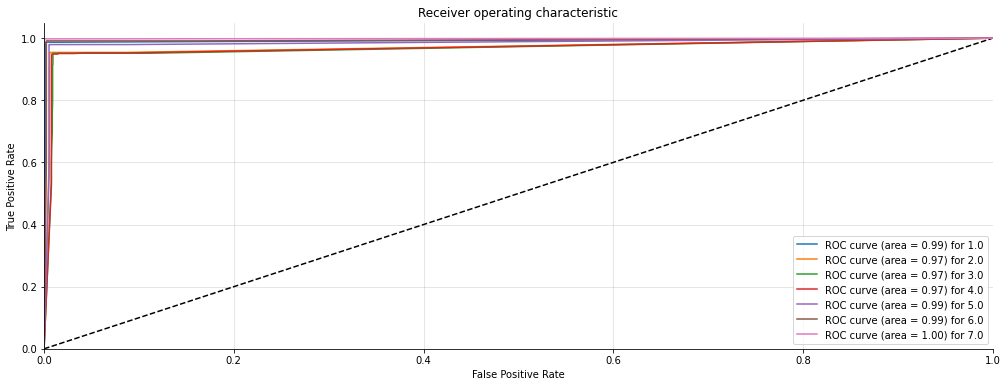

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


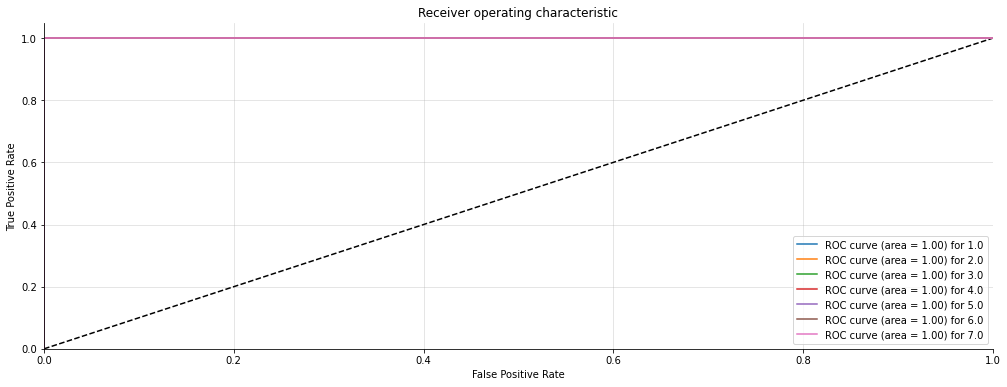

In [63]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def ETC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = ExtraTreesClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  ETC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [64]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['ExtraTreesClassifier'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8639880952380953
average Precision :0.8636088168014058
average Recall :0.8639880952380953
average F1 -score :0.8637064365059823
average RMSE 0.5962687037331302
average AUC score 0.9204599724435056


# 4.7.4 Adaboost 

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.60      0.64      0.62       462
         2.0       0.31      0.37      0.33       482
         3.0       0.32      0.29      0.30       510
         4.0       0.34      0.32      0.33       517
         5.0       0.28      0.34      0.31       467
         6.0       0.48      0.43      0.45       470
         7.0       0.70      0.55      0.62       452

    accuracy                           0.41      3360
   macro avg       0.43      0.42      0.42      3360
weighted avg       0.43      0.41      0.42      3360

Confusion Matrix: 
 [[296  73  29  29  12  10  13]
 [ 64 177  67  63  62  35  14]
 [ 46  93 149  94  55  58  15]
 [ 31  50 106 163 135  29   3]
 [ 23  55  63  90 158  74   4]
 [ 19  49  42  24  79 201  56]
 [ 18  79  15  13  67  11 249]]
Accuracy Score : 0.41458333333333336
Precision Score : 0.4272288470688421
Recall Score : 0.41458333333333336
F1 Score : 0.41837

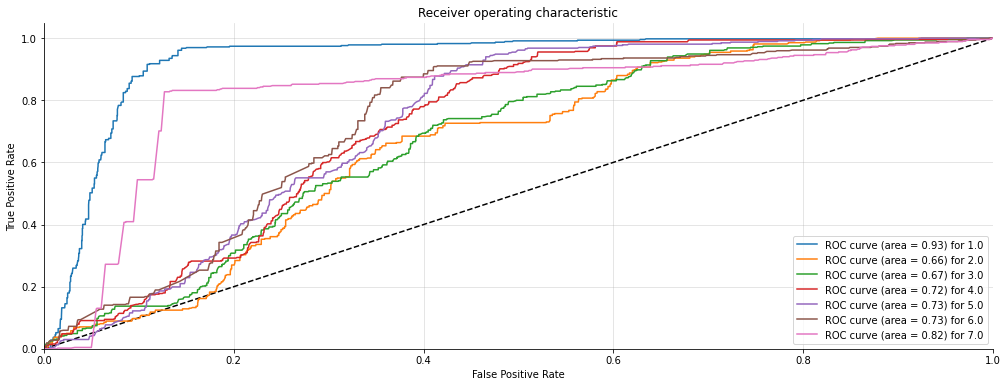

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.61      0.60      0.61       463
         2.0       0.35      0.42      0.38       485
         3.0       0.32      0.34      0.33       501
         4.0       0.30      0.28      0.29       515
         5.0       0.34      0.35      0.35       460
         6.0       0.43      0.44      0.44       484
         7.0       0.83      0.62      0.71       452

    accuracy                           0.43      3360
   macro avg       0.45      0.44      0.44      3360
weighted avg       0.45      0.43      0.44      3360

Confusion Matrix: 
 [[280  65  38  25  32  14   9]
 [ 53 206  83  41  56  38   8]
 [ 40  83 170  92  57  52   7]
 [ 31  67 113 142 107  48   7]
 [ 24  62  84  74 160  56   0]
 [ 21  95  38  38  52 215  25]
 [ 11  16   7  63   3  73 279]]
Accuracy Score : 0.43214285714285716
Precision Score : 0.448695877115714
Recall Score : 0.43214285714285716
F1 Score : 0.437563461476

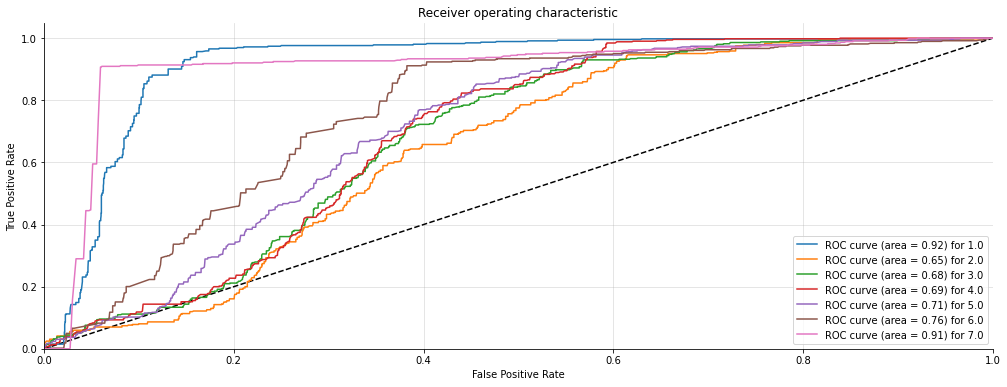

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.59      0.66      0.62       462
         2.0       0.33      0.37      0.35       482
         3.0       0.32      0.32      0.32       506
         4.0       0.36      0.29      0.32       526
         5.0       0.28      0.36      0.31       458
         6.0       0.47      0.41      0.44       475
         7.0       0.65      0.56      0.60       451

    accuracy                           0.42      3360
   macro avg       0.43      0.42      0.42      3360
weighted avg       0.43      0.42      0.42      3360

Confusion Matrix: 
 [[306  62  38  21  11   9  15]
 [ 73 178  80  41  54  35  21]
 [ 43  80 160  90  64  52  17]
 [ 41  42 112 152 131  37  11]
 [ 27  50  56  75 163  76  11]
 [  9  46  43  28  96 195  58]
 [ 20  77  14  12  70   7 251]]
Accuracy Score : 0.4181547619047619
Precision Score : 0.42602267422448975
Recall Score : 0.4181547619047619
F1 Score : 0.4194826

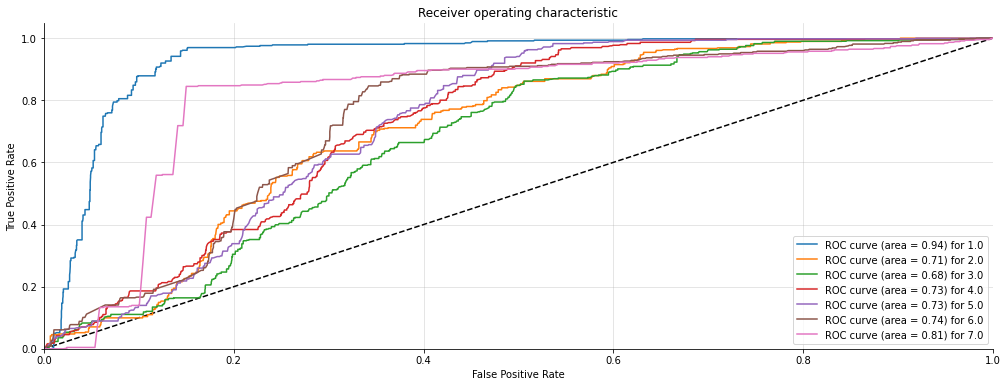

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.62      0.65      0.64       461
         2.0       0.34      0.40      0.37       488
         3.0       0.30      0.30      0.30       506
         4.0       0.39      0.28      0.33       516
         5.0       0.26      0.37      0.31       456
         6.0       0.38      0.41      0.40       471
         7.0       0.71      0.40      0.51       462

    accuracy                           0.40      3360
   macro avg       0.43      0.40      0.41      3360
weighted avg       0.43      0.40      0.40      3360

Confusion Matrix: 
 [[299  51  48  12  21  29   1]
 [ 53 194  87  31  75  33  15]
 [ 40  98 154  72  67  64  11]
 [ 36  57 100 145 128  46   4]
 [ 18  42  55  87 170  78   6]
 [ 18  43  48   7 121 194  40]
 [ 16  90  17  19  70  64 186]]
Accuracy Score : 0.39940476190476193
Precision Score : 0.4258919990929103
Recall Score : 0.39940476190476193
F1 Score : 0.40375104391

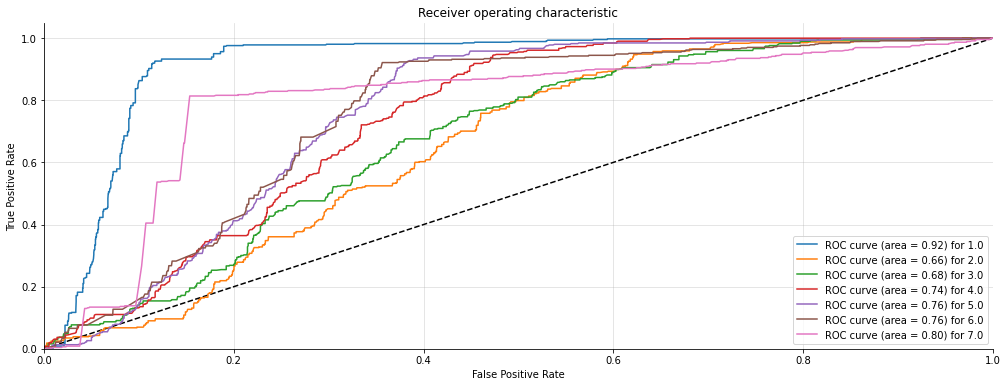

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.26      0.51      0.35       463
         2.0       0.40      0.22      0.29       491
         3.0       0.24      0.26      0.25       487
         4.0       0.30      0.24      0.27       518
         5.0       0.17      0.16      0.17       487
         6.0       0.35      0.29      0.32       462
         7.0       0.95      0.82      0.88       452

    accuracy                           0.35      3360
   macro avg       0.38      0.36      0.36      3360
weighted avg       0.38      0.35      0.35      3360

Confusion Matrix: 
 [[235  39  35  27  81  45   1]
 [136 109  74  37  94  38   3]
 [133  42 129  63  70  46   4]
 [149  30  85 125  65  58   6]
 [152  43  70  79  80  60   3]
 [ 88  10  57  89  80 134   4]
 [  3   0  77   1   0   1 370]]
Accuracy Score : 0.3517857142857143
Precision Score : 0.3759416303424967
Recall Score : 0.3517857142857143
F1 Score : 0.35325805343502

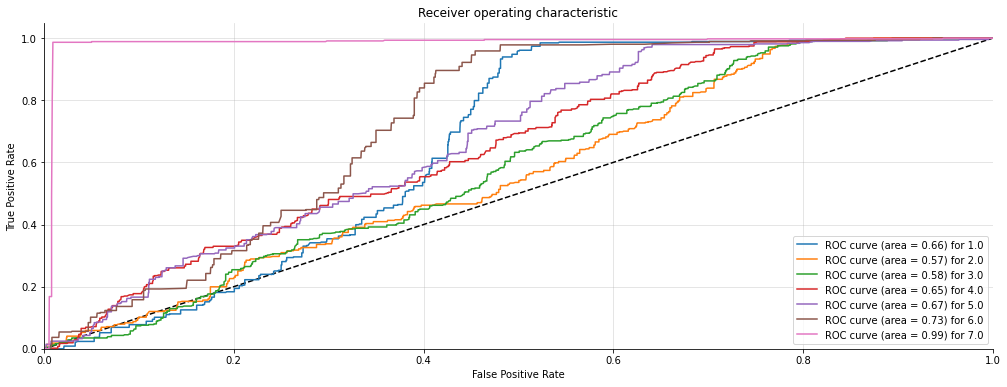

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.28      0.28      0.28       461
         2.0       0.23      0.18      0.20       495
         3.0       0.22      0.23      0.23       490
         4.0       0.23      0.21      0.22       519
         5.0       0.22      0.38      0.28       481
         6.0       0.34      0.23      0.28       465
         7.0       0.95      0.82      0.88       449

    accuracy                           0.33      3360
   macro avg       0.35      0.33      0.34      3360
weighted avg       0.35      0.33      0.33      3360

Confusion Matrix: 
 [[130  51  57  82 105  36   0]
 [ 87  91  64  80 111  56   6]
 [ 81  69 112  62 114  47   5]
 [ 64  55  68 107 188  32   5]
 [ 47  54  86  77 181  36   0]
 [ 53  74  36  58 131 109   4]
 [  0   0  78   0   1   0 370]]
Accuracy Score : 0.3273809523809524
Precision Score : 0.3463967103783128
Recall Score : 0.3273809523809524
F1 Score : 0.33

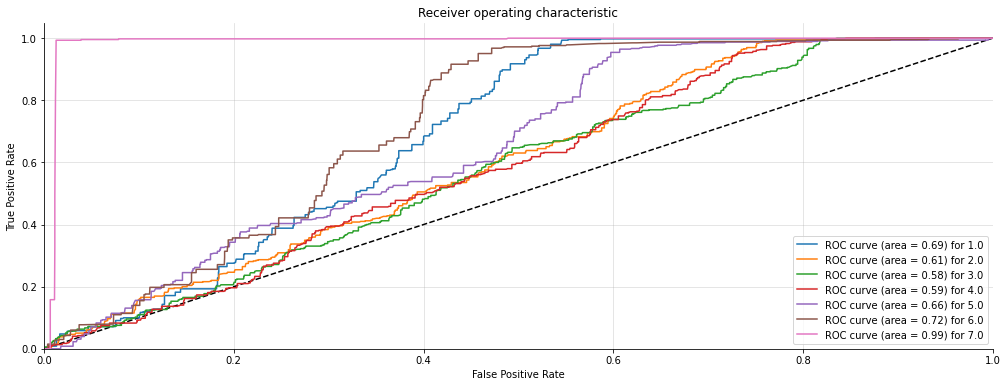

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.21      0.45      0.29       460
         2.0       0.20      0.15      0.17       502
         3.0       0.19      0.24      0.21       474
         4.0       0.30      0.17      0.22       527
         5.0       0.22      0.22      0.22       486
         6.0       0.29      0.19      0.23       459
         7.0       0.98      0.68      0.80       452

    accuracy                           0.29      3360
   macro avg       0.34      0.30      0.31      3360
weighted avg       0.34      0.29      0.30      3360

Confusion Matrix: 
 [[208  76  90  25  52   9   0]
 [180  73  71  69  72  36   1]
 [164  48 115  36  67  41   3]
 [170  60 118  88  68  22   1]
 [146  37 103  52 108  40   0]
 [118  64  51  20 118  88   0]
 [  1   0  73   0   0  71 307]]
Accuracy Score : 0.29375
Precision Score : 0.33677008743703846
Recall Score : 0.29375
F1 Score : 0.29981796926367454
(3360, 7) 

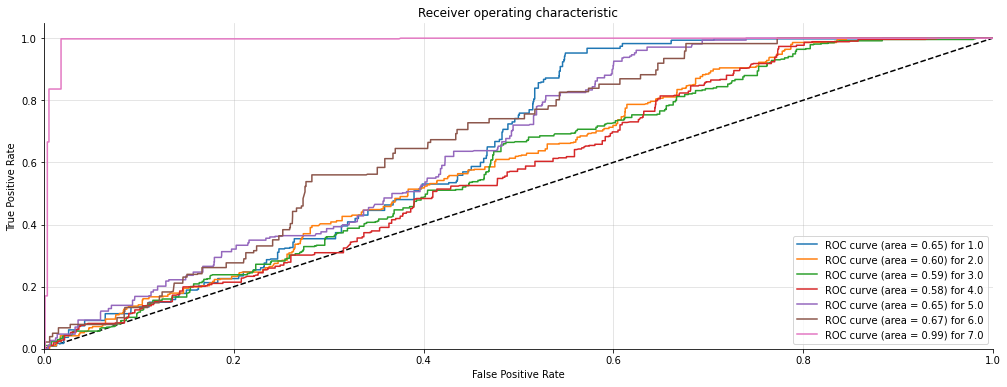

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.23      0.17      0.20       459
         2.0       0.33      0.15      0.21       496
         3.0       0.26      0.16      0.20       478
         4.0       0.10      0.12      0.11       523
         5.0       0.16      0.15      0.15       491
         6.0       0.19      0.50      0.27       462
         7.0       0.97      0.50      0.66       451

    accuracy                           0.24      3360
   macro avg       0.32      0.25      0.26      3360
weighted avg       0.31      0.24      0.25      3360

Confusion Matrix: 
 [[ 77  31  45  77  72 151   6]
 [ 53  75  34  77  53 204   0]
 [ 54  45  77  43  71 188   0]
 [ 74  25  59  62  67 234   2]
 [ 39  38  38  78  73 225   0]
 [ 32  14  41  27 119 229   0]
 [  0   0   0 227   0   0 224]]
Accuracy Score : 0.2431547619047619
Precision Score : 0.312740801040098
Recall Score : 0.2431547619047619
F1 Score : 0.250779296415

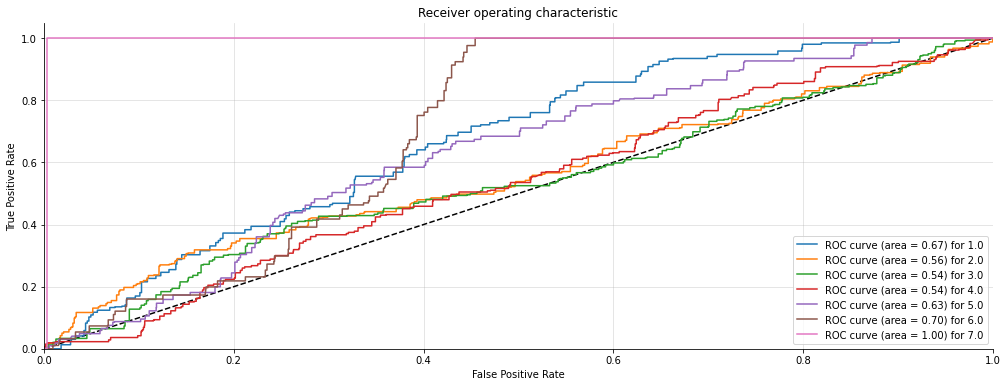

In [65]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def ADB(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = AdaBoostClassifier(n_estimators=500)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  ADB(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [66]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['AdaBoost'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.3600446428571429
average Precision :0.3874610783374878
average Recall :0.3600446428571429
average F1 -score :0.36429410232003845
average RMSE 2.0411468398151063
average AUC score 0.6263701073268079


# 4.7.5 Gradient boosting 

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.46      0.70      0.55       462
         2.0       0.42      0.37      0.40       482
         3.0       0.34      0.27      0.30       510
         4.0       0.38      0.33      0.35       517
         5.0       0.29      0.23      0.26       467
         6.0       0.37      0.39      0.38       470
         7.0       0.61      0.69      0.65       452

    accuracy                           0.42      3360
   macro avg       0.41      0.43      0.41      3360
weighted avg       0.41      0.42      0.41      3360

Confusion Matrix: 
 [[323  58  17   1  10  29  24]
 [ 93 178  54  49  46  39  23]
 [ 65  61 137 104  67  54  22]
 [ 74  39  94 169  70  46  25]
 [ 74  39  63  89 109  82  11]
 [ 52  31  21  22  69 184  91]
 [ 24  13  17  11   7  68 312]]
Accuracy Score : 0.42023809523809524
Precision Score : 0.4079439151842392
Recall Score : 0.42023809523809524
F1 Score : 0.40866

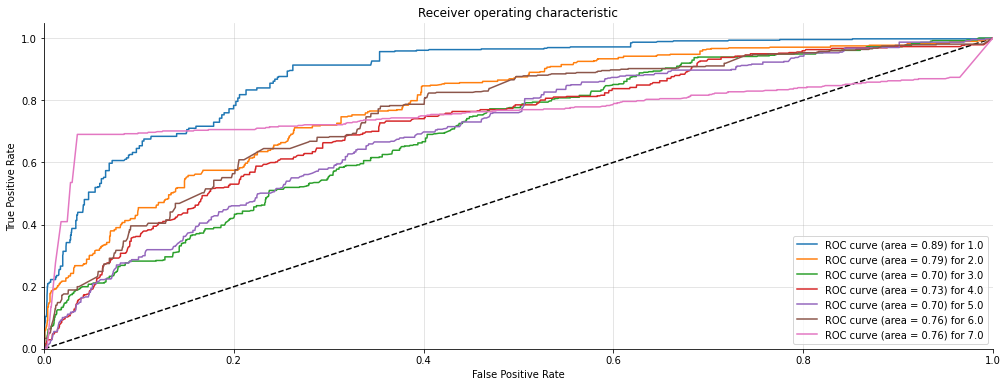

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.47      0.81      0.59       463
         2.0       0.22      0.20      0.21       485
         3.0       0.39      0.07      0.12       501
         4.0       0.33      0.25      0.28       515
         5.0       0.21      0.26      0.23       460
         6.0       0.33      0.27      0.30       484
         7.0       0.53      0.77      0.63       452

    accuracy                           0.37      3360
   macro avg       0.35      0.38      0.34      3360
weighted avg       0.35      0.37      0.33      3360

Confusion Matrix: 
 [[376   5   4   4  33  10  31]
 [122  99  21  38 117  42  46]
 [ 72 108  36  87  99  53  46]
 [ 80  93  12 129 106  35  60]
 [ 78  66   9  89 120  59  39]
 [ 59  79   8  38  87 131  82]
 [ 15   5   3   9   7  65 348]]
Accuracy Score : 0.36875
Precision Score : 0.35235932472069714
Recall Score : 0.36875
F1 Score : 0.33357306452056107
(3360, 7) (3360,

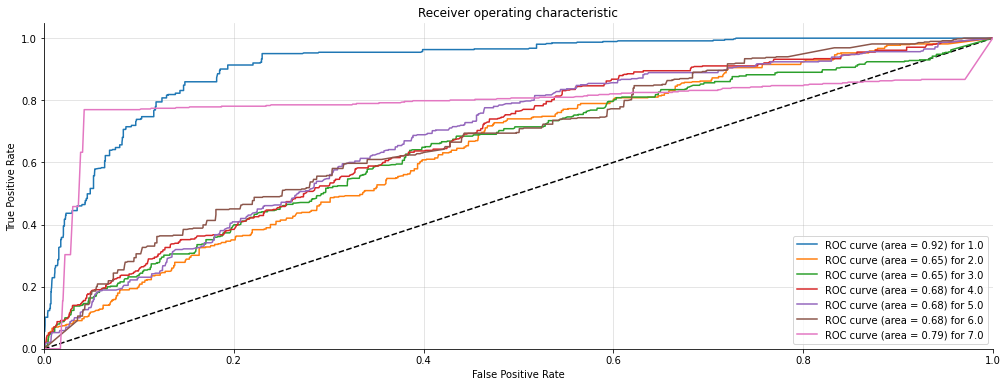

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.51      0.79      0.62       462
         2.0       0.41      0.40      0.41       482
         3.0       0.31      0.23      0.26       506
         4.0       0.39      0.23      0.29       526
         5.0       0.24      0.24      0.24       458
         6.0       0.52      0.64      0.57       475
         7.0       0.80      0.83      0.81       451

    accuracy                           0.47      3360
   macro avg       0.45      0.48      0.46      3360
weighted avg       0.45      0.47      0.45      3360

Confusion Matrix: 
 [[365  33  19   2  32  11   0]
 [103 192  49  32  63  35   8]
 [ 72 103 114  67  95  50   5]
 [ 85  63  97 119 119  42   1]
 [ 44  38  59  69 108 137   3]
 [ 23  19  24  10  16 305  78]
 [ 21  16   8   9  12  11 374]]
Accuracy Score : 0.4693452380952381
Precision Score : 0.4497090596976485
Recall Score : 0.4693452380952381
F1 Score : 0.45015926

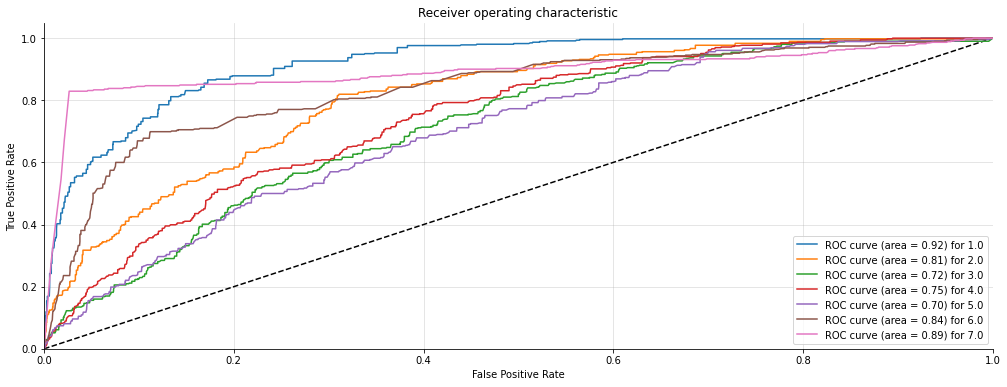

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.57      0.84      0.68       461
         2.0       0.52      0.48      0.50       488
         3.0       0.48      0.36      0.42       506
         4.0       0.44      0.34      0.39       516
         5.0       0.41      0.46      0.44       456
         6.0       0.58      0.60      0.59       471
         7.0       0.79      0.79      0.79       462

    accuracy                           0.55      3360
   macro avg       0.54      0.55      0.54      3360
weighted avg       0.54      0.55      0.54      3360

Confusion Matrix: 
 [[386  26  14  21  10   4   0]
 [ 82 234  49  47  43  29   4]
 [ 56  79 184  70  69  41   7]
 [ 69  43  83 178 121  22   0]
 [ 41  28  20  52 211 104   0]
 [ 19  16  10  17  41 282  86]
 [ 19  21  20  16  14   6 366]]
Accuracy Score : 0.5479166666666667
Precision Score : 0.5418859501917894
Recall Score : 0.5479166666666667
F1 Score : 0.5389530663210

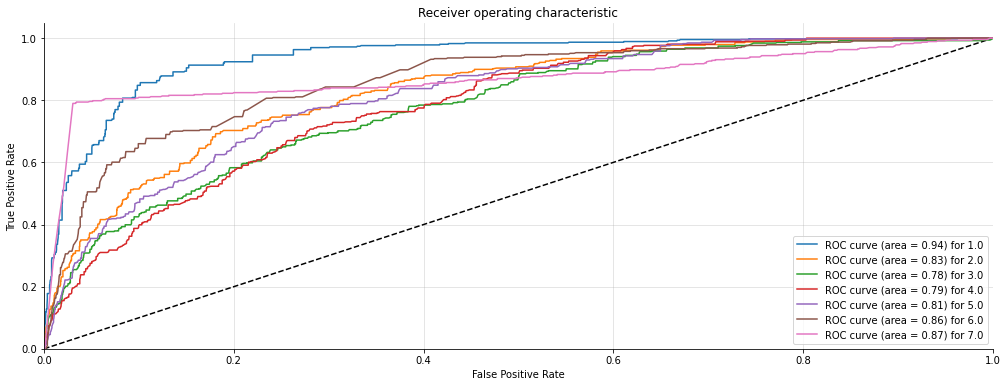

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.52      0.81      0.63       463
         2.0       0.39      0.28      0.32       491
         3.0       0.35      0.30      0.32       487
         4.0       0.48      0.36      0.41       518
         5.0       0.57      0.60      0.58       487
         6.0       0.51      0.56      0.53       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.55      3360
   macro avg       0.54      0.56      0.54      3360
weighted avg       0.54      0.55      0.53      3360

Confusion Matrix: 
 [[376  21   4   9  13  40   0]
 [100 137  80  54  66  54   0]
 [ 75 100 147  61  51  53   0]
 [ 85  59  72 184  63  55   0]
 [ 39  18  52  40 293  45   0]
 [ 49  17  66  38  30 257   5]
 [  2   1   0   1   0   2 446]]
Accuracy Score : 0.5476190476190477
Precision Score : 0.5371583657159558
Recall Score : 0.5476190476190477
F1 Score : 0.53478904947848

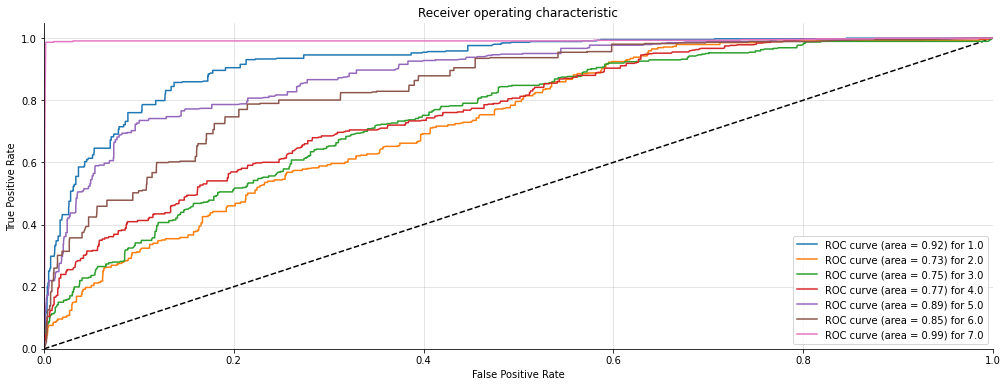

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.47      0.79      0.59       461
         2.0       0.33      0.28      0.31       495
         3.0       0.38      0.29      0.33       490
         4.0       0.40      0.30      0.34       519
         5.0       0.54      0.59      0.56       481
         6.0       0.47      0.45      0.46       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.52      3360
   macro avg       0.51      0.53      0.51      3360
weighted avg       0.51      0.52      0.50      3360

Confusion Matrix: 
 [[366  21  15  11  14  34   0]
 [130 139  63  56  53  54   0]
 [ 65  95 141  72  66  51   0]
 [ 79  69  74 155  80  62   0]
 [ 57  38  37  35 282  32   0]
 [ 76  52  44  54  27 207   5]
 [  0   1   0   1   0   1 446]]
Accuracy Score : 0.5166666666666667
Precision Score : 0.5060810412121226
Recall Score : 0.5166666666666667
F1 Score : 0.50

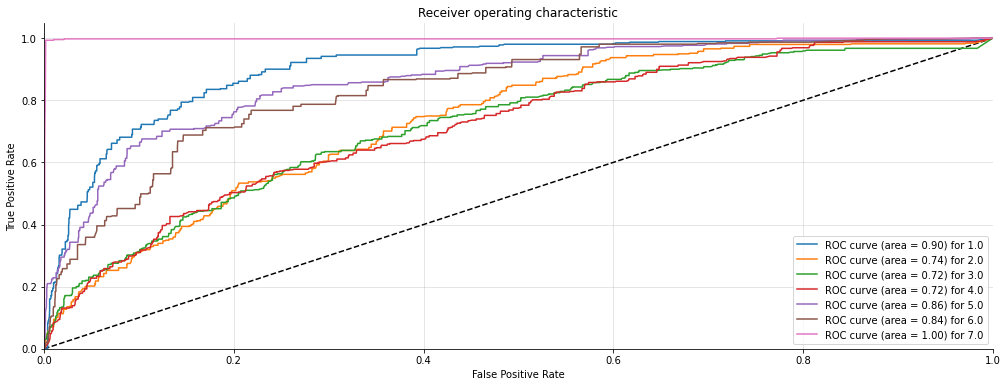

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.50      0.82      0.62       460
         2.0       0.41      0.17      0.24       502
         3.0       0.30      0.30      0.30       474
         4.0       0.49      0.40      0.44       527
         5.0       0.33      0.40      0.36       486
         6.0       0.48      0.47      0.48       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.50      3360
   macro avg       0.50      0.51      0.49      3360
weighted avg       0.50      0.50      0.48      3360

Confusion Matrix: 
 [[377   8  11  22  35   7   0]
 [ 92  84 114  69  83  60   0]
 [ 72  43 144  59 112  44   0]
 [ 83  33  72 209  70  60   0]
 [ 63  27  87  54 195  60   0]
 [ 67  12  57  13  94 216   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.4988095238095238
Precision Score : 0.4961902411868648
Recall Score : 0.4988095238095238
F1 Score : 0.4835072

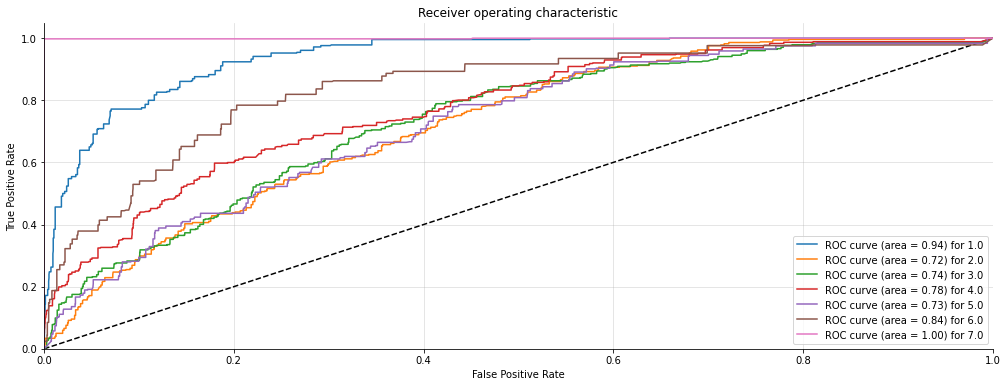

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.53      0.88      0.66       459
         2.0       0.32      0.24      0.27       496
         3.0       0.44      0.32      0.37       478
         4.0       0.33      0.29      0.31       523
         5.0       0.37      0.32      0.35       491
         6.0       0.48      0.57      0.52       462
         7.0       1.00      1.00      1.00       451

    accuracy                           0.51      3360
   macro avg       0.50      0.52      0.50      3360
weighted avg       0.49      0.51      0.49      3360

Confusion Matrix: 
 [[404   7   4  16   8  20   0]
 [113 118  68  58  86  53   0]
 [ 69  77 153  48  75  56   0]
 [ 76  80  62 152  67  86   0]
 [ 58  71  34  97 157  74   0]
 [ 42  18  26  86  26 264   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.5056547619047619
Precision Score : 0.48849996794403533
Recall Score : 0.5056547619047619
F1 Score : 0.4878099559

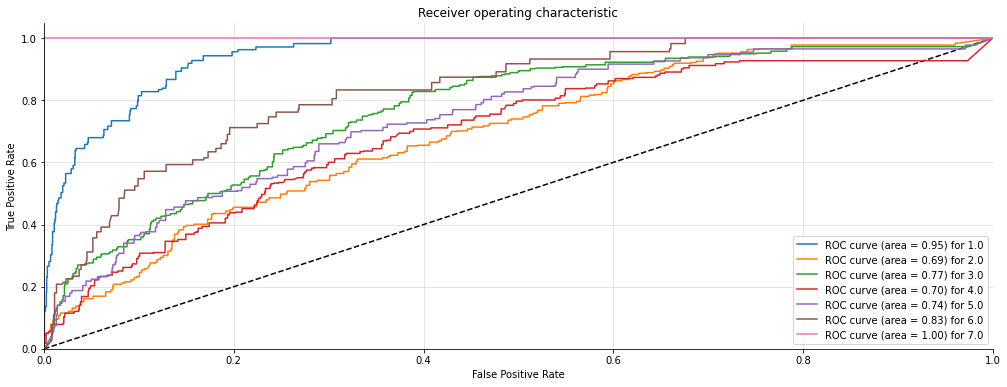

In [67]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def GBC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  GBC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [68]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['GradientBoost'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.484375
average Precision :0.4724784832316691
average Recall :0.484375
average F1 -score :0.4675820860403556
average RMSE 1.7602164343630466
average AUC score 0.6992027268460889


# 4.7.6  Bagging classfier

In [69]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       462
         2.0       0.81      0.86      0.83       482
         3.0       0.72      0.68      0.70       510
         4.0       0.66      0.67      0.66       517
         5.0       0.64      0.64      0.64       467
         6.0       0.73      0.70      0.72       470
         7.0       0.82      0.81      0.82       452

    accuracy                           0.76      3360
   macro avg       0.76      0.76      0.76      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  2 415  57   0   5   3   0]
 [  2  29 347 125   4   3   0]
 [  0   1  34 346 135   1   0]
 [  4   5  13  35 300 110   0]
 [  3  19  11   9  15 330  83]
 [ 10  26  20  13   9   6 368]]
Accuracy Score : 0.7583333333333333
Precision Score : 0.7577266402439039
Recall Score : 0.7583333333333333
F1 Score : 0.7577687

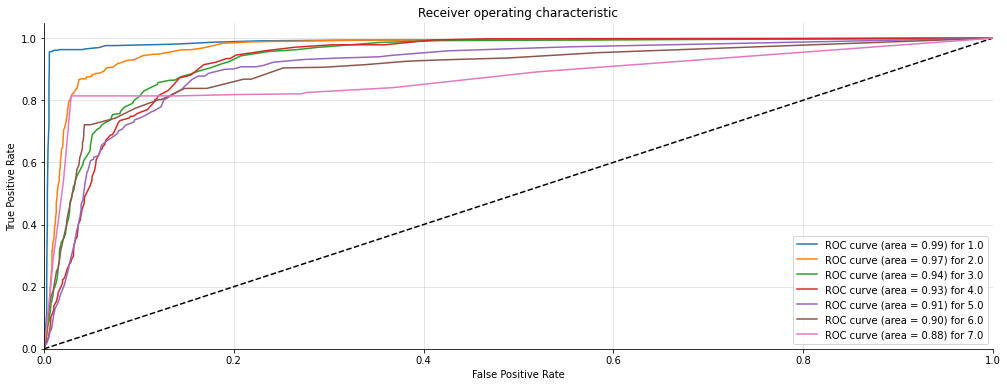

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.94      0.95      0.95       463
         2.0       0.82      0.86      0.84       485
         3.0       0.73      0.71      0.72       501
         4.0       0.67      0.67      0.67       515
         5.0       0.71      0.70      0.70       460
         6.0       0.82      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.80      3360
   macro avg       0.80      0.80      0.80      3360
weighted avg       0.80      0.80      0.80      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  2 419  48   4   7   5   0]
 [ 10  20 356 109   3   3   0]
 [  0   6  47 346 114   2   0]
 [  3  13  15  37 322  70   0]
 [  5  18  17  12   5 384  43]
 [  9  18   6   5   4   2 408]]
Accuracy Score : 0.7967261904761904
Precision Score : 0.7959402737966946
Recall Score : 0.7967261904761904
F1 Score : 0.7961651834111

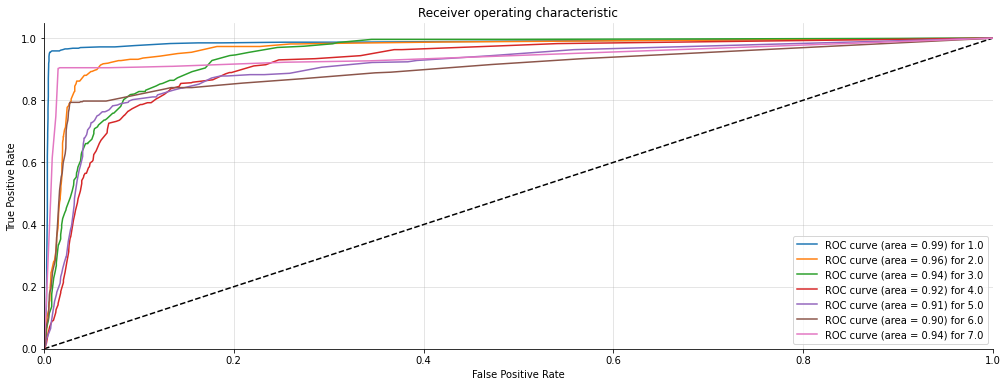

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.93      0.96      0.94       462
         2.0       0.82      0.85      0.84       482
         3.0       0.71      0.73      0.72       506
         4.0       0.68      0.63      0.65       526
         5.0       0.64      0.67      0.66       458
         6.0       0.72      0.67      0.70       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.76      3360
   macro avg       0.76      0.76      0.76      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [ 11 412  58   0   1   0   0]
 [  4  20 371 106   1   4   0]
 [  0   2  55 330 139   0   0]
 [  2   4   7  25 309 111   0]
 [  7  19  18  13  23 318  77]
 [ 10  27  17   9   8   6 374]]
Accuracy Score : 0.7607142857142857
Precision Score : 0.7594022647769669
Recall Score : 0.7607142857142857
F1 Score : 0.75954999

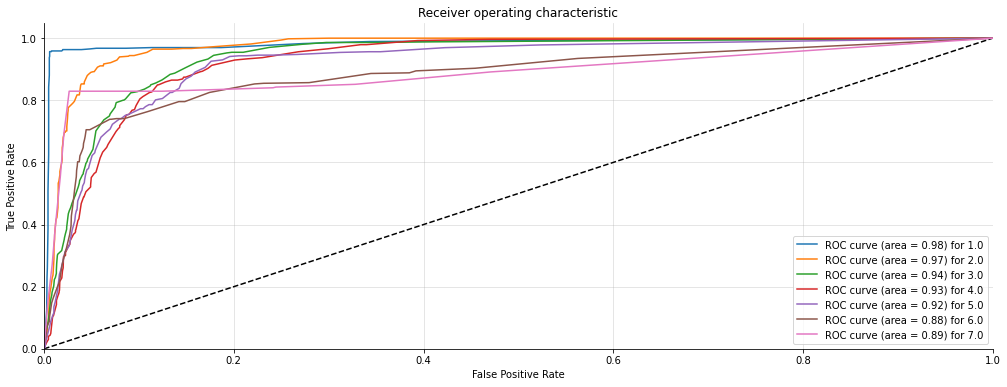

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       461
         2.0       0.82      0.84      0.83       488
         3.0       0.72      0.70      0.71       506
         4.0       0.67      0.66      0.67       516
         5.0       0.65      0.69      0.67       456
         6.0       0.73      0.71      0.72       471
         7.0       0.80      0.79      0.80       462

    accuracy                           0.76      3360
   macro avg       0.76      0.77      0.76      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[444  17   0   0   0   0   0]
 [  3 412  60   3   6   3   1]
 [  3  19 355 121   3   3   2]
 [  0   0  29 340 145   2   0]
 [  2   2   7  21 313 111   0]
 [  2  16  15  10   6 336  86]
 [ 13  34  25  11  10   4 365]]
Accuracy Score : 0.7633928571428571
Precision Score : 0.7633009589367373
Recall Score : 0.7633928571428571
F1 Score : 0.7631893904178

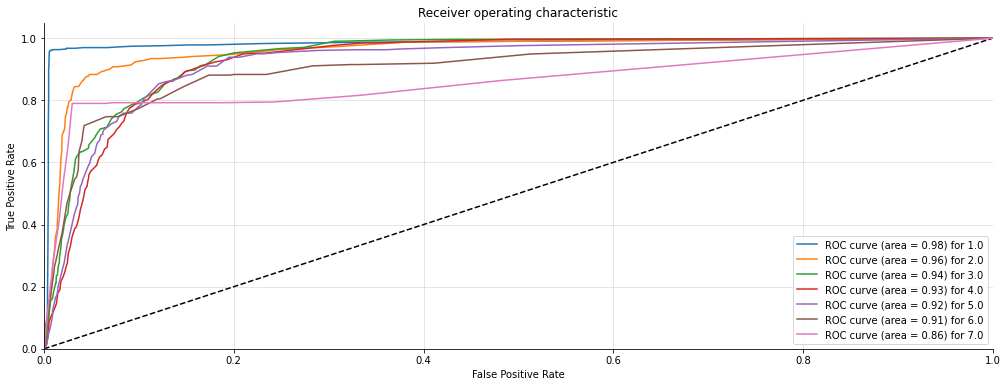

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.86      0.86       491
         3.0       0.82      0.80      0.81       487
         4.0       0.86      0.86      0.86       518
         5.0       0.90      0.92      0.91       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.90      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  17   1   0   2   1   0]
 [  5 424  48   4   7   3   0]
 [  9  25 390  57   5   1   0]
 [  3  15  22 445  32   1   0]
 [  1   5  11   9 450  11   0]
 [  1   4   3   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9047619047619048
Precision Score : 0.9045467178661727
Recall Score : 0.9047619047619048
F1 Score : 0.90461398478679

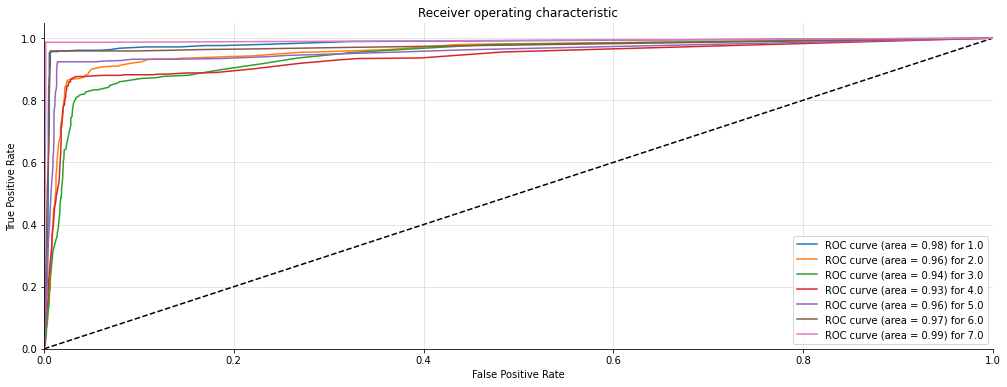

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       461
         2.0       0.85      0.85      0.85       495
         3.0       0.81      0.77      0.79       490
         4.0       0.83      0.82      0.82       519
         5.0       0.86      0.91      0.88       481
         6.0       0.95      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.89      3360
   macro avg       0.89      0.89      0.89      3360
weighted avg       0.89      0.89      0.89      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  8 422  48   4   9   4   0]
 [  8  27 375  69   7   4   0]
 [  3  19  23 427  47   0   0]
 [  1   7  10  15 436  12   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8907738095238096
Precision Score : 0.890165847040057
Recall Score : 0.8907738095238096
F1 Score : 0.890

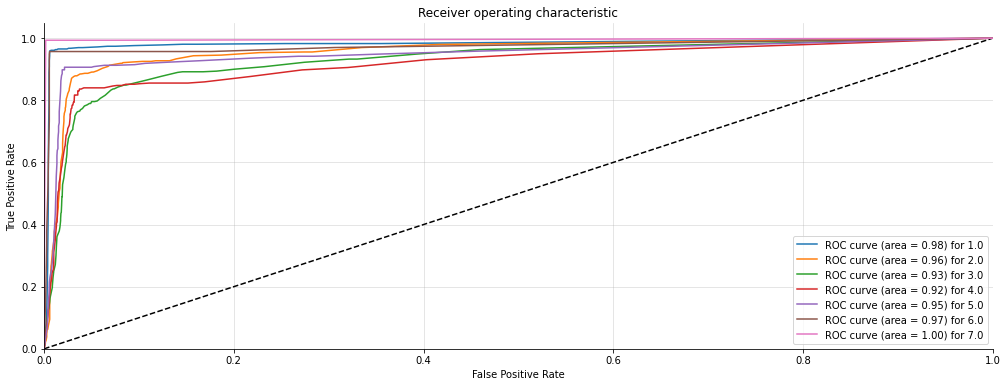

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.98      0.99      0.99       460
         2.0       0.95      0.93      0.94       502
         3.0       0.94      0.91      0.92       474
         4.0       0.95      0.94      0.95       527
         5.0       0.94      0.98      0.96       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.96      3360
   macro avg       0.96      0.96      0.96      3360
weighted avg       0.96      0.96      0.96      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  7 466  18   3   6   2   0]
 [  0  17 433  15   9   0   0]
 [  0   1  12 496  14   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9616071428571429
Precision Score : 0.9616231506094534
Recall Score : 0.9616071428571429
F1 Score : 0.9614949

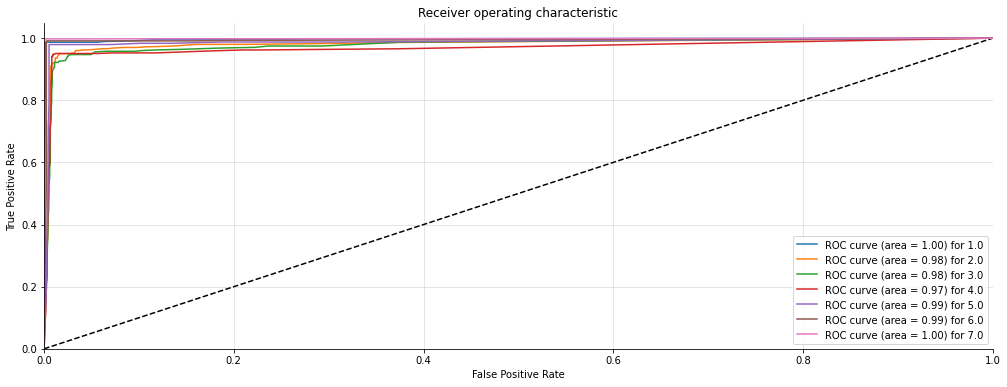

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       0.98      0.97      0.98       496
         3.0       0.99      0.97      0.98       478
         4.0       0.99      0.99      0.99       523
         5.0       0.98      1.00      0.99       491
         6.0       0.99      1.00      0.99       462
         7.0       1.00      1.00      1.00       451

    accuracy                           0.99      3360
   macro avg       0.99      0.99      0.99      3360
weighted avg       0.99      0.99      0.99      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  2 482   1   0   5   6   0]
 [  0   8 462   3   4   1   0]
 [  0   0   3 520   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.9901785714285715
Precision Score : 0.9902006520613122
Recall Score : 0.9901785714285715
F1 Score : 0.99014145885

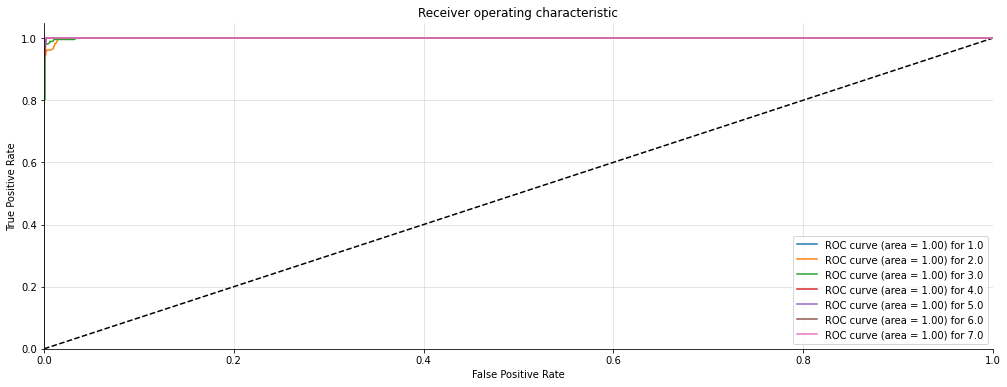

In [70]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
def BAG(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test,predictions,average='weighted'))
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    recal.append(recall_score(y_test,predictions,average='weighted'))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    f1.append(f1_score(y_test,predictions,average='weighted'))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    rms.append(np.sqrt(mean_squared_error(y_test,predictions)))
    aucscore.append(score_auc(y_test,predictions))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  BAG(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [71]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['BaggingClassifier'] = [np.mean(acc),np.mean(pre),np.mean(recal),np.mean(f1),np.mean(rms),np.mean(aucscore)]

average Accuracy :0.8533110119047619
average Precision :0.8528633131664123
average Recall :0.8533110119047619
average F1 -score :0.8529030510084701
average RMSE 0.658544931044962
average AUC score 0.9142229234908693


# Model Result Metrics display

In [73]:
metric_df

metric       XGB       SVM  OrdinalModel  LogisticModel  \
0   Accuracy  0.865216  0.672731      0.864844       0.306473   
1  Precision  0.865027  0.693954      0.864665       0.277301   
2     Recall  0.865216  0.672731      0.864844       0.306473   
3   F1 Score  0.865046  0.669372      0.864691       0.274929   
4       RMSE  0.598530  1.415965      0.598022       2.447818   
5  AUC score  0.921182  0.809363      0.920960       0.595746   

   DecisionTreeclasssifier  RandomForestClassifier  ExtraTreesClassifier  \
0                 0.863988                0.865327              0.863988   
1                 0.863609                0.865150              0.863609   
2                 0.863988                0.865327              0.863988   
3                 0.863706                0.865173              0.863706   
4                 0.596269                0.601287              0.596269   
5                 0.920460                0.921249              0.920460   

   AdaBoost  GradientBoost  BaggingClassifier  
0  0.360045       0.484375           0.853311  
1  0.387461       0.472478           0.852863  
2  0.360045       0.484375           0.853311  
3  0.364294       0.467582           0.852903  
4  2.041147       1.760216           0.658545  
5  0.626370       0.699203           0.914223